In [114]:
import os
import socket
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import types as T, functions as F, SparkSession
from pyspark.sql.window import Window
from pyspark import StorageLevel
from jinja2 import Environment, FileSystemLoader
import datetime
import json

In [115]:
LOGIN = "ljamschikova-362109"  # Your gateway.st login
APP_NAME = "EDA"  # Any name for your Spark-app

In [116]:
NORMALIZED_APP_NAME = APP_NAME.replace('/', '_').replace(':', '_').replace(' ', '_').replace('\\', '_')

APPS_TMP_DIR = os.path.join(os.getcwd(), "tmp")
APPS_CONF_DIR = os.path.join(os.getcwd(), "conf")
APPS_LOGS_DIR = os.path.join(os.getcwd(), "logs")
LOG4J_PROP_FILE = os.path.join(APPS_CONF_DIR, "pyspark-log4j-{}.properties".format(NORMALIZED_APP_NAME))
LOG_FILE = os.path.join(APPS_LOGS_DIR, 'pyspark-{}.log'.format(NORMALIZED_APP_NAME))
EXTRA_JAVA_OPTIONS = (
    "-Dlog4j.configuration=file://{} "
    "-Dspark.hadoop.dfs.replication=1 "
    "-Dhttps.protocols=TLSv1.0,TLSv1.1,TLSv1.2,TLSv1.3"
    .format(LOG4J_PROP_FILE)
)

LOCAL_IP = socket.gethostbyname(socket.gethostname())

In [117]:
for directory in [APPS_CONF_DIR, APPS_LOGS_DIR, APPS_TMP_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

env = Environment(loader=FileSystemLoader('/opt'))
template = env.get_template("pyspark_log4j.properties.template")
template.stream(logfile=LOG_FILE).dump(LOG4J_PROP_FILE)

In [118]:
spark = (
    SparkSession
    .builder
    .appName(APP_NAME)
    
    # Master URI/configuration
    .master("k8s://https://10.32.7.103:6443")
    
    .config("spark.driver.host", LOCAL_IP)
    
    # Web-UI port for your Spark-app
    .config("spark.ui.port", "4040")
    .config("spark.driver.bindAddress", "0.0.0.0")
    
    # How many CPU cores allocate to driver process
    .config("spark.driver.cores", "2")
    
    # How many RAM allocate to driver process
    .config("spark.driver.memory", "4g")
    
    # How many executors to create
    .config("spark.executor.instances", "3")
    
    # How many CPU cores allocate to each executor
    .config("spark.executor.cores", '2')
    
    # How many RAM allocate to each executor
    .config("spark.executor.memory", "4g")
    
    # How many extra RAM allocate to each executor pod to handle with JVM overheads
    # Total pod RAM = 'spark.executor.memory' + ('spark.executor.memory' * 'spark.kubernetes.memoryOverheadFactor')
    .config("spark.kubernetes.memoryOverheadFactor", "0.2")
    
    # How many RAM from the pool allocate to store the data
    # Additional info: https://spark.apache.org/docs/latest/tuning.html#memory-management-overview
    .config("spark.memory.fraction", "0.6")
    .config("spark.memory.storageFraction", "0.5")
    
    .config("spark.network.timeout", "180s")
    .config("spark.sql.autoBroadcastJoinThreshold", "-1")
    .config("spark.driver.extraJavaOptions", EXTRA_JAVA_OPTIONS)
    
    # Namespace to create executor pods. You are allowed to create pods only in your own namespace
    .config("spark.kubernetes.namespace", LOGIN)
    
    # Extra labels to your driver/executor pods in Kubernetes
    .config("spark.kubernetes.driver.label.appname", APP_NAME)
    .config("spark.kubernetes.executor.label.appname", APP_NAME)
    
    # Spark executor image
    .config("spark.kubernetes.container.image", f"node03.st:5000/spark-executor:{LOGIN}")

    .config("spark.kubernetes.container.image.pullPolicy", "Always")
    
    # If true - delete completed/failed pods. 
    # If your executors goes down you can set 'false' to check logs and troubleshoot your app.
    .config("spark.kubernetes.executor.deleteOnTermination", "true")
    
    .config("spark.local.dir", "/tmp/spark")
    .getOrCreate()
)

In [119]:
!hdfs dfs -ls /home/ljamschikova-362109

Found 15 items
-rw-r--r--   3 ljamschikova-362109 ljamschikova-362109      66301 2023-05-30 18:00 /home/ljamschikova-362109/-
-rw-r--r--   3 ljamschikova-362109 ljamschikova-362109      66301 2023-05-30 18:05 /home/ljamschikova-362109/Channels_0_100.csv
-rw-r--r--   3 ljamschikova-362109 ljamschikova-362109    3845448 2023-05-30 19:06 /home/ljamschikova-362109/Channels_full.csv
-rw-r--r--   3 ljamschikova-362109 ljamschikova-362109   10409122 2023-06-01 18:57 /home/ljamschikova-362109/Channels_full.json
-rw-r--r--   3 ljamschikova-362109 ljamschikova-362109    4478853 2023-06-02 19:12 /home/ljamschikova-362109/channels.json
drwxr-xr-x   - ljamschikova-362109 ljamschikova-362109          0 2023-06-14 09:43 /home/ljamschikova-362109/filtered_videos_df.json
drwxr-xr-x   - ljamschikova-362109 ljamschikova-362109          0 2023-06-14 11:27 /home/ljamschikova-362109/processed
-rw-r--r--   3 ljamschikova-362109 ljamschikova-362109 7746845030 2023-05-30 19:29 /home/ljamschikova-362109/videos_

In [120]:
DATA_PATH = "hdfs:///home/ljamschikova-362109"

In [121]:
channels_df = spark.read.json(f"{DATA_PATH}/channels.json")

In [122]:
channels_df.printSchema()

root
 |-- Channel_id: string (nullable = true)
 |-- Channel_name: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- PublishedAt: string (nullable = true)
 |-- Subscribers: long (nullable = true)
 |-- Total_videos: long (nullable = true)
 |-- Views: long (nullable = true)
 |-- playlist_id: string (nullable = true)



In [12]:
channels_df.count()

5489

In [13]:
channels_df.sort(F.col('Subscribers').desc()).select(F.col('Channel_name'), F.col('Subscribers')).show(10)

+--------------------+-----------+
|        Channel_name|Subscribers|
+--------------------+-----------+
|         Like Nastya|  105000000|
|          Get Movies|   46400000|
|                  A4|   45400000|
|      Маша и Медведь|   42500000|
|          TEDx Talks|   38200000|
|          Mister Max|   23700000|
|           Miss Katy|   23400000|
|Kinder Spielzeug ...|   21700000|
|      Eva Bravo Play|   21400000|
|        Tsuriki Show|   21200000|
+--------------------+-----------+
only showing top 10 rows



In [16]:
channels_df.sort(F.col('Views').desc()).select(F.col('Channel_name'), F.col('Views')).show(10)

+--------------+-----------+
|  Channel_name|      Views|
+--------------+-----------+
|   Like Nastya|89568048973|
|Маша и Медведь|35901404365|
|    Get Movies|30365773137|
|  Tsuriki Show|29492911207|
|            A4|22090229318|
|          LEGO|20271829928|
|    Mister Max|15450151342|
|     Miss Katy|14589950134|
|           NBA|12417386845|
|   Chapitosiki|12128532638|
+--------------+-----------+
only showing top 10 rows



In [17]:
channels_df.sort(F.col('Total_videos').desc()).select(F.col('Channel_name'), F.col('Total_videos')).show(10)

+--------------------+------------+
|        Channel_name|Total_videos|
+--------------------+------------+
|  Телеканал Хабар 24|      374085|
|                 ТСН|      234330|
|            24 Канал|      203456|
|          TEDx Talks|      197024|
|Various Artists -...|      118883|
|        Khabar NEWS |       74491|
|  Euronews по-русски|       68789|
|АТН: новости Бела...|       66528|
|Телеканал Астана ...|       61915|
|       Телеканал ОНТ|       53691|
+--------------------+------------+
only showing top 10 rows



In [123]:
videos_df = spark.read.json(f"{DATA_PATH}/videos_part*.json")

In [19]:
videos_df.printSchema()

root
 |-- ChannelId: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Published_date: string (nullable = true)
 |-- Thumbnails: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- caption: string (nullable = true)
 |-- categoryId: string (nullable = true)
 |-- commentCount: string (nullable = true)
 |-- definition: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- licensedContent: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: string (nullable = true)



## Cast data types 


**Cast integers and doubles**

In [602]:
(videos_df
 .select(F.col("views"), F.col("views").cast('double').isNull().alias("Value "))
 .where(F.col("Value ") == 'true')
 .select('views')
 .distinct()
 .collect())

[Row(views=None), Row(views='недоступно')]

In [603]:
(videos_df
 .select(F.col("commentCount"), F.col("commentCount").cast('int').isNull().alias("Value "))
 .where(F.col("Value ") == 'true')
 .select('commentCount')
 .distinct()
 .collect())

[Row(commentCount="['камчатка', 'камчатка канал', 'камчатка видео', 'новости камчатки', 'события камчатки', 'происшествия камчатка', 'камчатка 2019', 'камчатка 2020', 'трансляция камчатка', 'камчатка сегодня', 'камчатка онлайн', 'камчатка прямой эфир', 'камчатка тв', 'камчатка эфир', 'масс медиа', 'масс медиа канал', 'Масс-Медиа News', 'Масс-Медиа News канал', 'массмедиа']"),
 Row(commentCount=None),
 Row(commentCount="['казан кабоб', 'как пожарить картошку целиком', 'телятина', 'свинина', 'жарить', 'картошка', 'мясо', 'казан', 'кебаб', 'Qozon kabob', 'Время есть', 'Время есть казан кебаб']"),
 Row(commentCount='недоступно')]

In [604]:
(videos_df
 .select(F.col("likes"), F.col("likes").cast('int').isNull().alias("Value "))
 .where(F.col("Value ") == 'true')
 .select('likes')
 .distinct()
 .collect())

[Row(likes=None), Row(likes='недоступно')]

In [605]:
(videos_df
 .select(F.col("categoryId"), F.col("categoryId").cast('int').isNull().alias("Value "))
 .where(F.col("Value ") == 'true')
 .select('categoryId')
 .distinct()
 .collect())

[Row(categoryId='https://i.ytimg.com/vi/u__-dHwDdqo/hqdefault.jpg'),
 Row(categoryId='False'),
 Row(categoryId=None),
 Row(categoryId='https://i.ytimg.com/vi/40uwrtlnpOY/hqdefault.jpg')]

In [124]:
videos_df = (videos_df
             .withColumn("views", videos_df.views.cast('double'))
             .withColumn("categoryId", videos_df.categoryId.cast('int'))
             .withColumn("commentCount", videos_df.commentCount.cast('double'))
             .withColumn("likes", videos_df.likes.cast('double')))

## Filter rows with unknown views, likes and comment count

In [607]:
unavailable_views = (videos_df.where((F.col('views').isNull()) | 
                                     (F.col('likes').isNull()) | 
                                     (F.col('commentCount').isNull())).count())
print(f'Количество видео с неизвестными просмотрами, лайками или количеством комментариев: {unavailable_views}')

Количество видео с неизвестными просмотрами, лайками или количеством комментариев: 331488


In [125]:
filtered_videos_df = (videos_df.where((F.col('views').isNotNull()) & 
                                      (F.col('likes').isNotNull()) & 
                                      (F.col('commentCount').isNotNull())))

In [609]:
videos_number = filtered_videos_df.count()
channels_number = channels_df.count()
print(f"Number of collected channels: {channels_number}")
print(f"Number of collected videous: {videos_number}")

Number of collected channels: 5489
Number of collected videous: 3977851


## Continue type casting

**Process dates (origine RFC 3339 format, “Z” means UTC+0). Convert it to Moscow time UTC+3.**

In [439]:
(filtered_videos_df
 .withColumn('Published_date_proc', F.to_timestamp(filtered_videos_df.Published_date) + F.expr('INTERVAL 3 HOURS'))
 .select(F.col('Published_date'), F.col('Published_date_proc')).show(10))

+--------------------+-------------------+
|      Published_date|Published_date_proc|
+--------------------+-------------------+
|2023-04-09T11:19:27Z|2023-04-09 14:19:27|
|2023-03-27T10:25:56Z|2023-03-27 13:25:56|
|2023-02-22T06:30:19Z|2023-02-22 09:30:19|
|2023-02-01T12:27:49Z|2023-02-01 15:27:49|
|2023-02-01T09:56:00Z|2023-02-01 12:56:00|
|2023-01-31T10:32:59Z|2023-01-31 13:32:59|
|2023-01-23T12:52:24Z|2023-01-23 15:52:24|
|2023-01-22T21:34:08Z|2023-01-23 00:34:08|
|2022-11-21T08:36:58Z|2022-11-21 11:36:58|
|2022-11-07T12:09:40Z|2022-11-07 15:09:40|
+--------------------+-------------------+
only showing top 10 rows



In [126]:
filtered_videos_df = (filtered_videos_df
                      .withColumn('Published_date', 
                                  F.to_timestamp(filtered_videos_df.Published_date) + 
                                  F.expr('INTERVAL 3 HOURS')))

**Duration in seconds**

In [127]:
import pandas as pd

@F.pandas_udf("int")
def parse_iso8601_duration(str_duration: pd.Series) -> pd.Series:
    return str_duration.apply(lambda duration: (pd.Timedelta(duration).seconds))

filtered_videos_df.withColumn("duration_in_seconds", parse_iso8601_duration(F.col("duration"))).select(F.col('duration'), F.col('duration_in_seconds')).show(10)

+--------+-------------------+
|duration|duration_in_seconds|
+--------+-------------------+
| PT5M29S|                329|
| PT8M47S|                527|
| PT4M29S|                269|
|   PT15S|                 15|
|   PT42S|                 42|
|   PT59S|                 59|
|   PT10S|                 10|
|   PT14S|                 14|
|PT14M50S|                890|
| PT3M12S|                192|
+--------+-------------------+
only showing top 10 rows



In [128]:
filtered_videos_df = filtered_videos_df.withColumn("duration", parse_iso8601_duration(F.col("duration")))

**Cast boolean types**

In [129]:
filtered_videos_df = (filtered_videos_df
                      .withColumn("licensedContent", filtered_videos_df.licensedContent.cast('boolean'))
                      .withColumn("caption", filtered_videos_df.caption.cast('boolean'))
                      .withColumn("status", filtered_videos_df.status.cast('boolean')))

In [26]:
filtered_videos_df.printSchema()

root
 |-- ChannelId: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Published_date: timestamp (nullable = true)
 |-- Thumbnails: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- caption: boolean (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- commentCount: double (nullable = true)
 |-- definition: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- licensedContent: boolean (nullable = true)
 |-- likes: double (nullable = true)
 |-- status: boolean (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: double (nullable = true)



## General statistics

In [27]:
row = filtered_videos_df.select(F.min('Published_date').alias('min_date'), F.max('Published_date').alias('max_date')).first()
row.asDict()

{'min_date': datetime.datetime(2006, 11, 22, 14, 41, 4),
 'max_date': datetime.datetime(2023, 5, 25, 11, 30, 44)}

In [446]:
row = filtered_videos_df.select(F.min('views').alias('min_views'), F.max('views').alias('max_views')).first()
row.asDict()

{'min_views': 0.0, 'max_views': 4554931536.0}

In [447]:
filtered_videos_df.sort(F.col('views').desc()).select(F.col('Title'), F.col('views')).show(10, truncate=False)


+--------------------------------------------------------------------------------------+-------------+
|Title                                                                                 |views        |
+--------------------------------------------------------------------------------------+-------------+
|Маша и Медведь (Masha and The Bear) - Маша плюс каша (17 Серия)                       |4.554931536E9|
|Маша и Медведь (Masha and The Bear) - Приятного аппетита (24 Серия)                   |1.441135071E9|
|Маша и Медведь (Masha and The Bear) - Большая стирка (18 Серия)                       |1.35105534E9 |
|Песенки для детей - Едет трактор - мультик про машинки                                |1.194331146E9|
|Маша и Медведь (Masha and The Bear) - Подкидыш (23 Серия)                             |8.39578605E8 |
|Маша и Медведь (Masha and The Bear) - Раз, два, три! Ёлочка, гори! (3 Серия)          |8.3951674E8  |
|Маша и Медведь - Сладкая жизнь 🍭 (Серия 33)                             

In [448]:
filtered_videos_df.sort(F.col('views').asc()).select(F.col('Title'), F.col('views')).show(10, truncate=False)

+--------------------------------------------------------------------+-----+
|Title                                                               |views|
+--------------------------------------------------------------------+-----+
|Григорий Сельский. FREE WI-FI. Электромузей в Ростокино             |0.0  |
|Отечество в моей душе. ГМИИ                                         |0.0  |
|Художник в зеркале сцены. Собрание В. Солянникова. ГМИИ             |0.0  |
|В поисках обитаемого пространства. Скульптор Алексей Григорьев. ММСИ|0.0  |
|Западноевропейские шпалеры XVI-XX вв.. ГМИИ                         |0.0  |
|Большая шестигранная витрина в ЦГВГ ФСБ. 2013                       |0.0  |
|Интермузей-2005                                                     |0.0  |
|Вокруг рельефа. ГМИИ                                                |0.0  |
|Открытие ЦЭВДиЮ Мусейон. ГМИИ.  27 января 2006                      |0.0  |
|Интермузей-2008                                                     |0.0  |

## Ploting histograms


Visualisation guide https://github.com/roshankoirala/pySpark_tutorial/blob/master/Data_visualization_in_pySpark%20.ipynb

In [38]:
import matplotlib.pyplot as plt

In [39]:
def histogram(df, col, bins=100, xname=None, yname=None):
    vals = df.select(col).rdd.flatMap(lambda x: x).histogram(bins)
    
    width = vals[0][1] - vals[0][0]
    loc = [vals[0][0] + (i+1) * width for i in range(len(vals[1]))]
    
    plt.bar(loc, vals[1], width=width)
    plt.xlabel(xname or col)
    plt.ylabel(yname)
    plt.show()

In [154]:
def boxplot(df, col, group_by, samp_size=10000): 
    
    # Selecting sample for the large dataset 
    # For samll data sampling is not done. For the large data 
    # sample size is the specified number. 
    
    true_samp_size = min(samp_size/df.count(), 1.0)
    pd_df = df.sample(False, true_samp_size).toPandas()
    
    # Making plot 
    pd_df.boxplot(col, by=group_by, figsize=(15, 8))
    plt.ylabel(col)
    plt.title(None)
    plt.show()

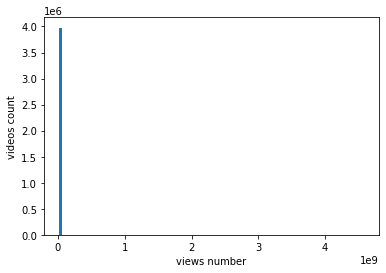

In [451]:
histogram(filtered_videos_df, 'views', xname='views number', yname='videos count')

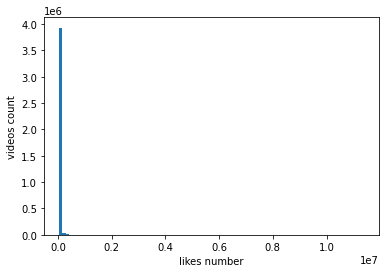

In [452]:
histogram(filtered_videos_df, 'likes', xname='likes number', yname='videos count')

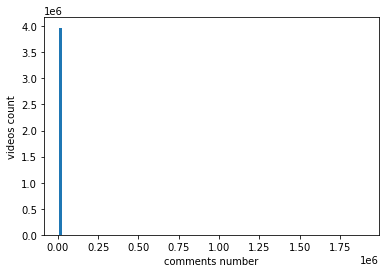

In [453]:
histogram(filtered_videos_df, 'commentCount', xname='comments number', yname='videos count')

In [130]:
filtered_videos_df = (filtered_videos_df
                      .withColumn('log_views', F.log(F.col('views') + 1).cast("Double"))
                      .withColumn('log_likes', F.log(F.col('likes') + 1).cast("Double"))
                      .withColumn('log_commentCount', F.log(F.col('commentCount') + 1).cast("Double")))

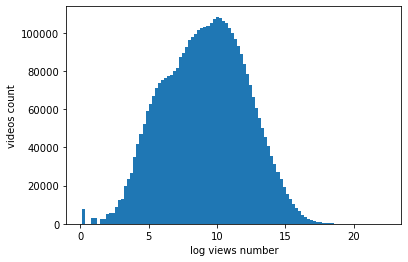

In [469]:
histogram(filtered_videos_df, 'log_views', xname='log views number', yname='videos count')

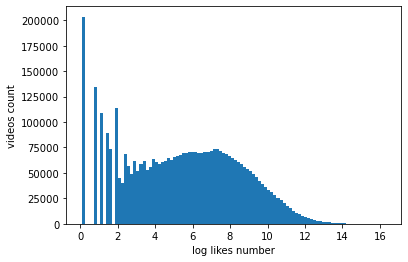

In [470]:
histogram(filtered_videos_df, 'log_likes', xname='log likes number', yname='videos count')

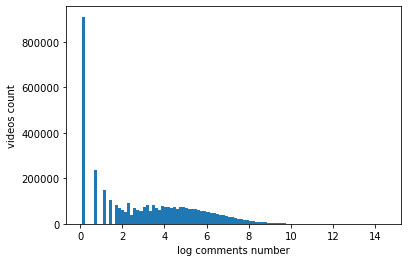

In [471]:
histogram(filtered_videos_df, 'log_commentCount', xname='log comments number', yname='videos count')

In [482]:
print(f"Процент видео с нулевым количеством просмотров: {filtered_videos_df.where(F.col('views') == 0).count() / filtered_videos_df.count()}")

Процент видео с нулевым количеством просмотров: 0.0018882054657150306


In [483]:
print(f"Процент видео с нулевым количеством лайков: {filtered_videos_df.where(F.col('likes') == 0).count() / filtered_videos_df.count()}")

Процент видео с нулевым количеством лайков: 0.05115928173277481


In [458]:
print(f"Процент видео с нулевым количеством коментариев: {filtered_videos_df.where(F.col('commentCount') == 0).count() / filtered_videos_df.count()}")

Процент видео с нулевым количеством коментариев: 0.22907695637669687


In [459]:
print("Среднее значение количества просмотров видео с нулевым количеством коментариев: ")
filtered_videos_df.where(F.col('commentCount') == 0).select(F.mean('views')).show()

Среднее значение количества просмотров видео с нулевым количеством коментариев: 
+------------------+
|        avg(views)|
+------------------+
|311157.91257349926|
+------------------+



Гистограмма распределения просмотров видео с нулевым количеством коментариев: 


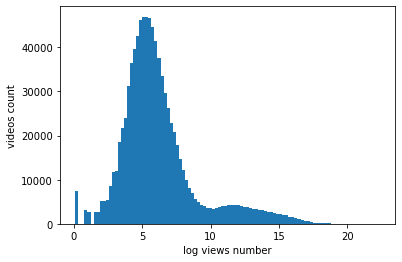

In [474]:
print("Гистограмма распределения просмотров видео с нулевым количеством коментариев: ")
histogram(filtered_videos_df.where(F.col('commentCount') == 0), 'log_views', xname='log views number', yname='videos count')

Гистограмма распределения просмотров видео с ненулевым количеством коментариев: 


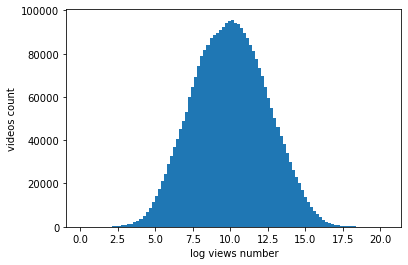

In [475]:
print("Гистограмма распределения просмотров видео с ненулевым количеством коментариев: ")
histogram(filtered_videos_df.where(F.col('commentCount') != 0), 'log_views', xname='log views number', yname='videos count')

Гистограмма распределения просмотров видео предназначенных для детей: 


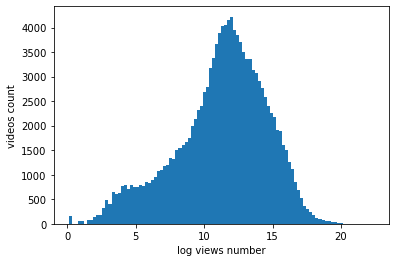

In [476]:
print("Гистограмма распределения просмотров видео предназначенных для детей: ")
histogram(filtered_videos_df.where(F.col('status') == True), 'log_views', xname='log views number', yname='videos count')

Гистограмма распределения просмотров видео предназначенных для детей: 


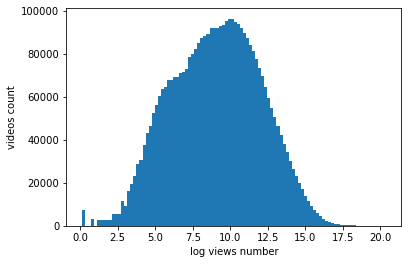

In [477]:
print("Гистограмма распределения просмотров видео предназначенных для детей: ")
histogram(filtered_videos_df.where(F.col('status') == False), 'log_views', xname='log views number', yname='videos count')

## Design target

In [131]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

unlist = udf(lambda x: float(list(x)[0]), DoubleType())

for i in ["log_views", "log_likes", "log_commentCount"]:
    assembler = VectorAssembler(inputCols=[i], outputCol=i+"_Vect")

    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    pipeline = Pipeline(stages=[assembler, scaler])

    filtered_videos_df = pipeline.fit(filtered_videos_df).transform(filtered_videos_df).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

In [132]:
filtered_videos_df = filtered_videos_df.withColumn('popularity', 
                                                   (F.col('log_views_Scaled') + 
                                                    F.col('log_likes_Scaled')  +
                                                    F.col('log_commentCount_Scaled')))

In [30]:
(filtered_videos_df
 .select('Title', 'log_commentCount_Scaled', 'log_likes_Scaled', 'log_views_Scaled', 'popularity')
 .sort(F.col('popularity').desc())
 .show(10))

(filtered_videos_df
 .select('Title', 'log_commentCount_Scaled', 'log_likes_Scaled', 'log_views_Scaled', 'popularity')
 .sort(F.col('popularity').asc())
 .show(10))

+-----------------------+-----------------------+------------------+------------------+------------------+
|                  Title|log_commentCount_Scaled|  log_likes_Scaled|  log_views_Scaled|        popularity|
+-----------------------+-----------------------+------------------+------------------+------------------+
|   Дворец для Путина...|     0.9999999999999999|0.9444134338628788|0.8390408235518507|2.7834542574147294|
|BIGBANG - 뱅뱅뱅 (BA...|     0.8821827314491478|0.9661132781209415|0.9113901723994113|2.7596861819695007|
|   BIGBANG - FANTAST...|     0.8780432554639888|0.9390848097179987|0.9033500607306005| 2.720478125912588|
|   Я ПОТЕРЯЛ ПАМЯТЬ ...|     0.9150434010698314|0.9313027637501481|0.8042407875506449|2.6505869523706242|
|   24 Часа в ДЕТСКОМ...|     0.8791194901018982|0.9357271630929337|0.8199019393592585|2.6347485925540903|
|   24 часа В Машине ...|     0.8804935544191183|0.9377664086606046|0.8123012633711535|2.6305612264508764|
|   Вернулись в ШКОЛУ...|     0.89575851

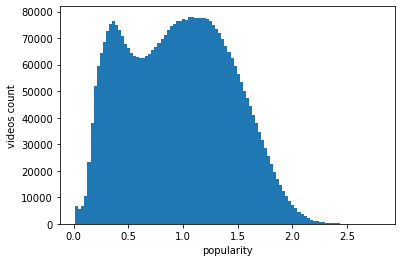

In [820]:
histogram(filtered_videos_df, 'popularity', xname='popularity', yname='videos count')

## Time of collected and popularity

In [133]:
filtered_videos_df = filtered_videos_df.withColumn('Year', F.year(F.col('Published_date')))
filtered_videos_df = filtered_videos_df.withColumn('Month', F.month(F.col('Published_date')))
filtered_videos_df = filtered_videos_df.withColumn('dayofweek', F.dayofweek(F.col('Published_date')))
filtered_videos_df = filtered_videos_df.withColumn('hour', F.hour(F.col('Published_date')))

<AxesSubplot:title={'center':'Количество опубликованных видео по годам'}, xlabel='Year'>

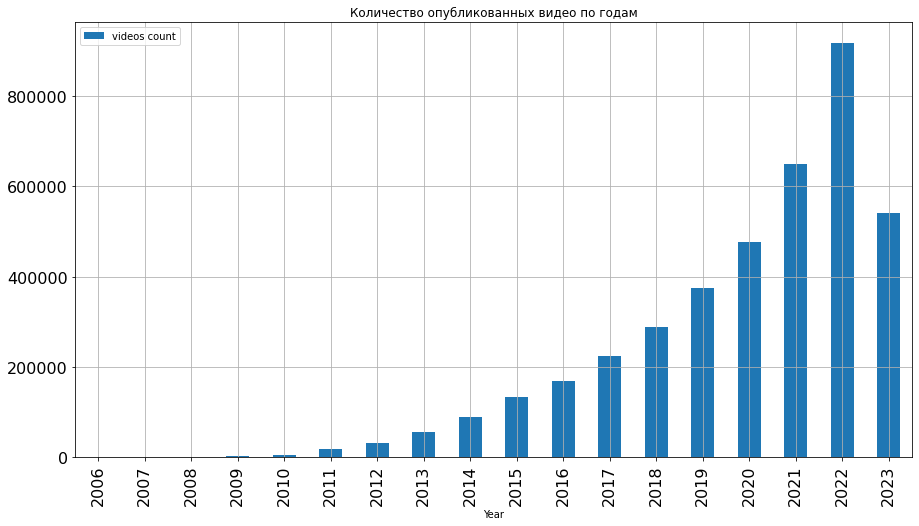

In [550]:
data_to_plot = (filtered_videos_df
                .groupby('Year')
                .agg(F.count('popularity').name('videos count'))
                .select('Year', 'videos count')
                .orderBy('Year', ascending=True)
                .toPandas())
data_to_plot.plot.bar(x='Year', y="videos count", figsize=(15,8), title='Количество опубликованных видео по годам', lw=3, fontsize=16, grid=True)

DataFrame[ChannelId: string, Description: string, Published_date: timestamp, Thumbnails: string, Title: string, caption: boolean, categoryId: int, commentCount: double, definition: string, duration: int, licensedContent: boolean, likes: double, status: boolean, tags: string, views: double, log_views: double, log_likes: double, log_commentCount: double, log_views_Scaled: double, log_likes_Scaled: double, log_commentCount_Scaled: double, popularity: double, Year: int, Month: int, dayofweek(: int, dayofweek: int]

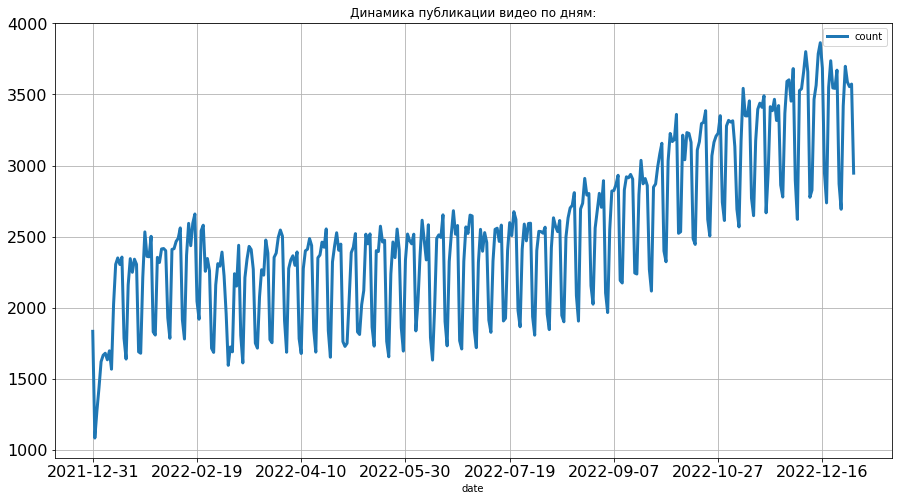

In [536]:
filtered_videos_df = filtered_videos_df.withColumn('date', F.date_format(F.col('Published_date'), "yyyy-MM-dd"))
data_to_plot = (filtered_videos_df
                .where(F.col('Published_date') > F.to_date(F.lit('2021-12-31')).cast('timestamp'))
                .where(F.col('Published_date') < F.to_date(F.lit('2023-01-01')).cast('timestamp'))
                .groupby('date')
                .agg(F.count('popularity').name('count'))
                .select('date', 'count')
                .orderBy("date", ascending=True)
                .toPandas())
data_to_plot.plot.line(x="date", y="count", figsize=(15, 8), title='Динамика публикации видео по дням:', lw=3, fontsize=16, grid=True)
filtered_videos_df.drop('date')

DataFrame[ChannelId: string, Description: string, Published_date: timestamp, Thumbnails: string, Title: string, caption: boolean, categoryId: int, commentCount: double, definition: string, duration: int, licensedContent: boolean, likes: double, status: boolean, tags: string, views: double, log_views: double, log_likes: double, log_commentCount: double, log_views_Scaled: double, log_likes_Scaled: double, log_commentCount_Scaled: double, popularity: double, Year: int, Month: int, dayofweek(: int]

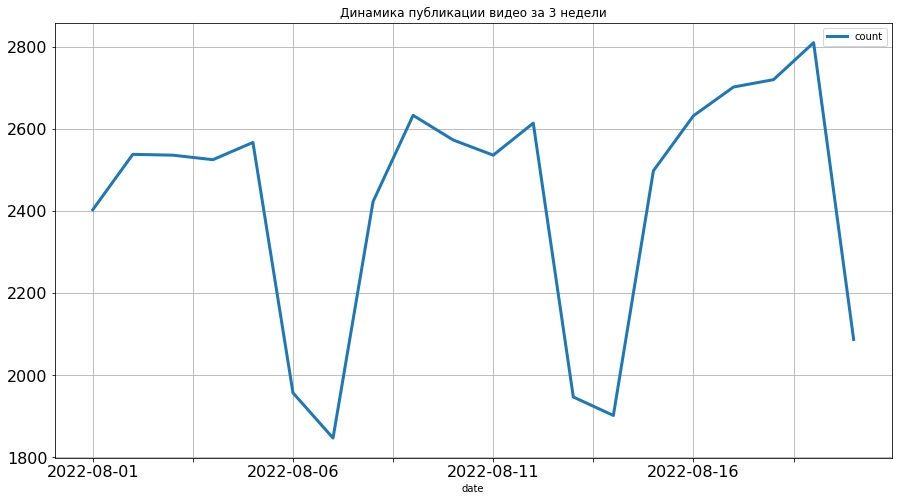

In [531]:
filtered_videos_df = filtered_videos_df.withColumn('date', F.date_format(F.col('Published_date'), "yyyy-MM-dd"))
data_to_plot = (filtered_videos_df
                .where(F.col('Published_date') >= F.to_date(F.lit('2022-08-1')).cast('timestamp'))
                .where(F.col('Published_date') <= F.to_date(F.lit('2022-08-21')).cast('timestamp'))
                .groupby('date')
                .agg(F.count('popularity').name('count'))
                .select('date', 'count')
                .orderBy("date", ascending=True)
                .toPandas())
data_to_plot.plot.line(x="date", y="count", figsize=(15, 8), title='Динамика публикации видео за 3 недели', lw=3, fontsize=16, grid=True)
filtered_videos_df.drop('date')

<AxesSubplot:title={'center':'Количество опубликованных видео по месяцам'}, xlabel='Month'>

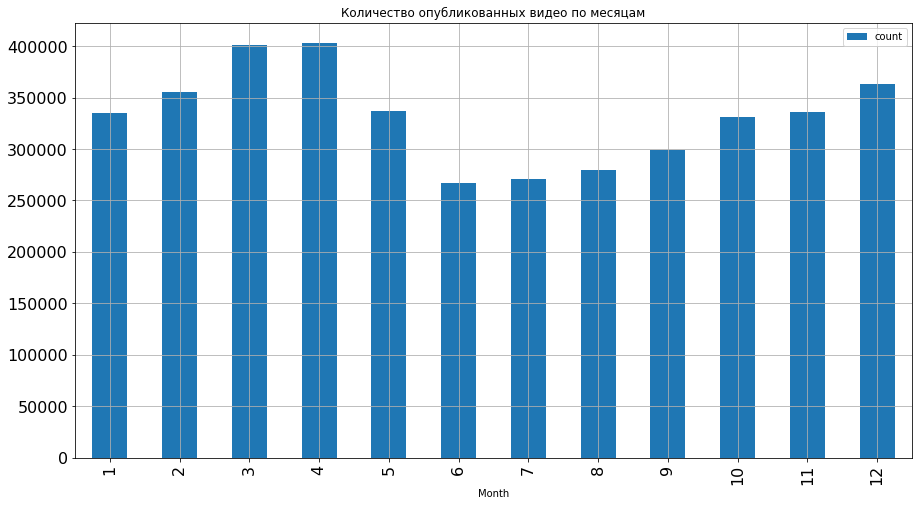

In [542]:
data_to_plot = (filtered_videos_df
                .groupby('Month')
                .agg(F.count('popularity').name('count'))
                .select('Month', 'count')
                .orderBy('Month', ascending=True)
                .toPandas())
data_to_plot.plot.bar(x='Month', y="count", figsize=(15,8), title='Количество опубликованных видео по месяцам', lw=3, fontsize=16, grid=True)

<AxesSubplot:title={'center':'Количество опубликованных видео по дням недели'}, xlabel='dayofweek'>

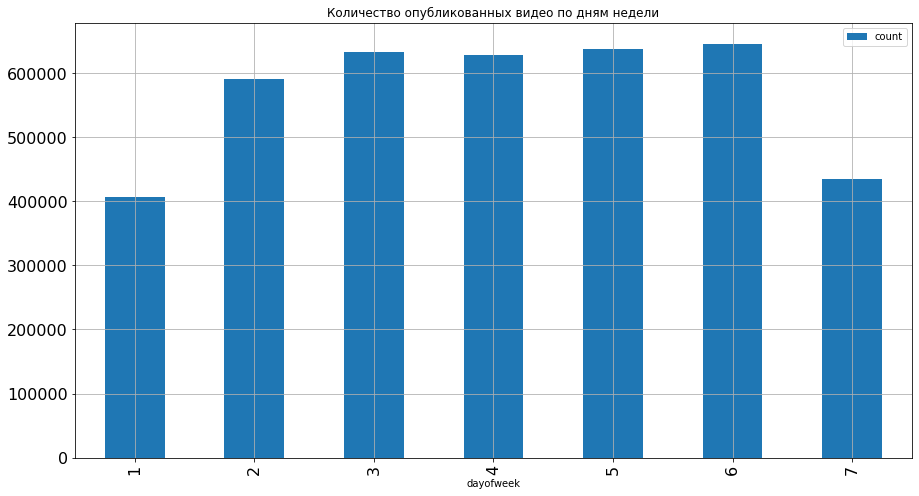

In [537]:
data_to_plot = (filtered_videos_df
                .groupby('dayofweek')
                .agg(F.count('popularity').name('count'))
                .select('dayofweek', 'count')
                .orderBy("dayofweek", ascending=True)
                .toPandas())
data_to_plot.plot.bar(x="dayofweek", y="count", figsize=(15,8), title='Количество опубликованных видео по дням недели', lw=3, fontsize=16, grid=True)

<AxesSubplot:title={'center':'Количество опубликованных видео по часам'}, xlabel='hour'>

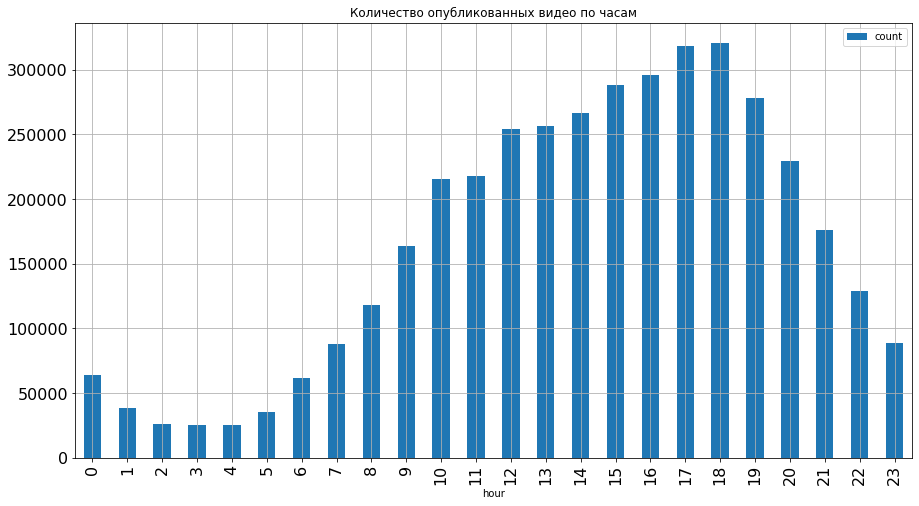

In [35]:
data_to_plot = (filtered_videos_df
                .groupby('hour')
                .agg(F.count('popularity').name('count'))
                .select('hour', 'count')
                .orderBy("hour", ascending=True)
                .toPandas())
data_to_plot.plot.bar(x="hour", y="count", figsize=(15,8), title='Количество опубликованных видео по часам', lw=3, fontsize=16, grid=True)

DataFrame[ChannelId: string, Description: string, Published_date: timestamp, Thumbnails: string, Title: string, caption: boolean, categoryId: int, commentCount: double, definition: string, duration: int, licensedContent: boolean, likes: double, status: boolean, tags: string, views: double, log_views: double, log_likes: double, log_commentCount: double, log_views_Scaled: double, log_likes_Scaled: double, log_commentCount_Scaled: double, popularity: double, Year: int, Month: int, dayofweek(: int, dayofweek: int]

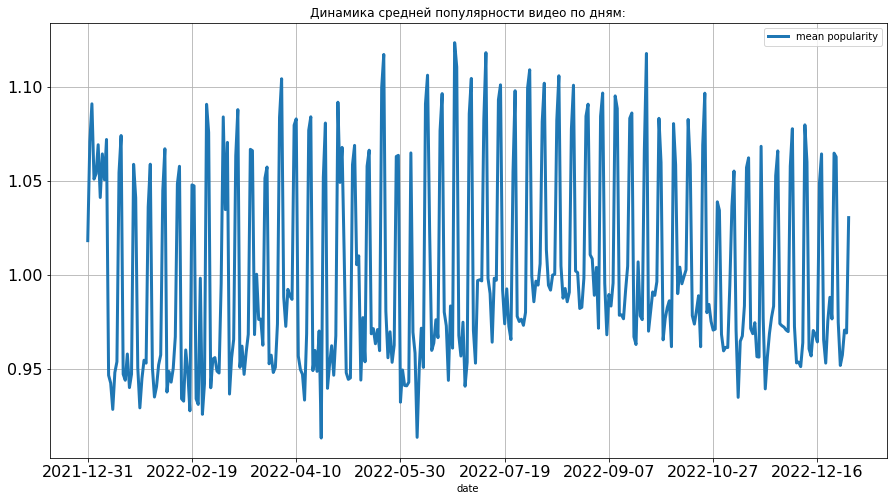

In [539]:
filtered_videos_df = filtered_videos_df.withColumn('date', F.date_format(F.col('Published_date'), "yyyy-MM-dd"))
data_to_plot = (filtered_videos_df
                .where(F.col('Published_date') > F.to_date(F.lit('2021-12-31')).cast('timestamp'))
                .where(F.col('Published_date') < F.to_date(F.lit('2023-01-01')).cast('timestamp'))
                .groupby('date')
                .agg(F.mean('popularity').name('mean popularity'))
                .select('date', 'mean popularity')
                .orderBy("date", ascending=True)
                .toPandas())
data_to_plot.plot.line(x="date", y="mean popularity", figsize=(15, 8), title='Динамика средней популярности видео по дням:', lw=3, fontsize=16, grid=True)
filtered_videos_df.drop('date')

DataFrame[ChannelId: string, Description: string, Published_date: timestamp, Thumbnails: string, Title: string, caption: boolean, categoryId: int, commentCount: double, definition: string, duration: int, licensedContent: boolean, likes: double, status: boolean, tags: string, views: double, log_views: double, log_likes: double, log_commentCount: double, log_views_Scaled: double, log_likes_Scaled: double, log_commentCount_Scaled: double, popularity: double, Year: int, Month: int, dayofweek(: int, dayofweek: int]

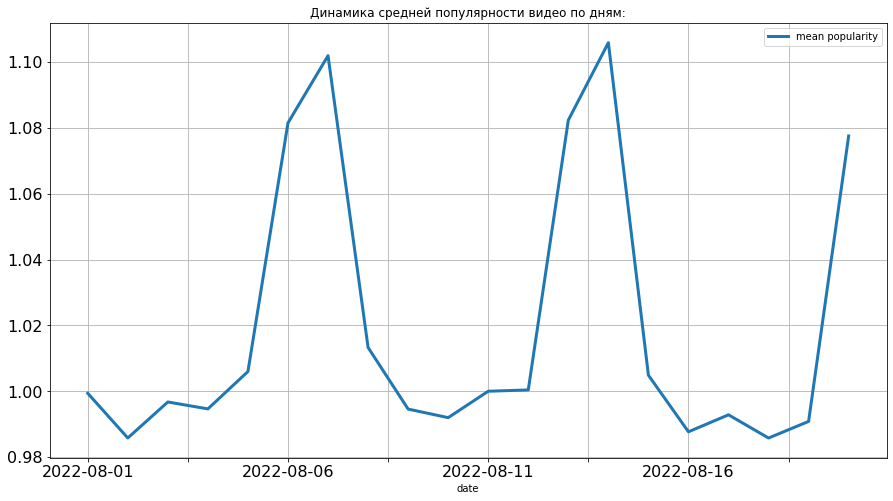

In [540]:
filtered_videos_df = filtered_videos_df.withColumn('date', F.date_format(F.col('Published_date'), "yyyy-MM-dd"))
data_to_plot = (filtered_videos_df
                .where(F.col('Published_date') > F.to_date(F.lit('2022-08-01')).cast('timestamp'))
                .where(F.col('Published_date') < F.to_date(F.lit('2022-08-21')).cast('timestamp'))
                .groupby('date')
                .agg(F.mean('popularity').name('mean popularity'))
                .select('date', 'mean popularity')
                .orderBy("date", ascending=True)
                .toPandas())
data_to_plot.plot.line(x="date", y="mean popularity", figsize=(15, 8), title='Динамика средней популярности видео по дням:', lw=3, fontsize=16, grid=True)
filtered_videos_df.drop('date')

<AxesSubplot:title={'center':'Средняя популярность видео по месяцам'}, xlabel='Month'>

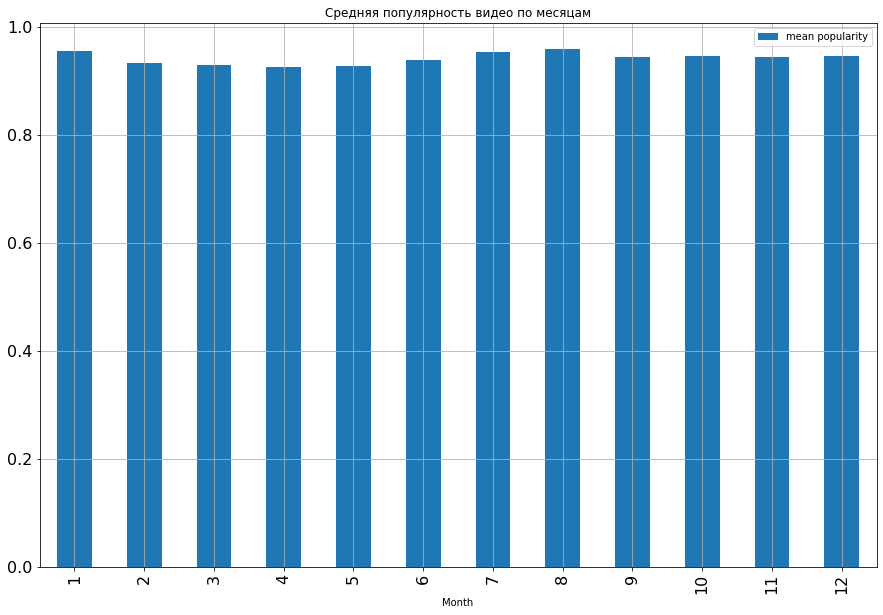

In [543]:
data_to_plot = (filtered_videos_df
                .groupby('Month')
                .agg(F.mean('popularity').name('mean popularity'))
                .select('Month', 'mean popularity')
                .orderBy("Month", ascending=True)
                .toPandas())
data_to_plot.plot.bar(x="Month", y="mean popularity", figsize=(15,10), title='Средняя популярность видео по месяцам', lw=3, fontsize=16, grid=True)

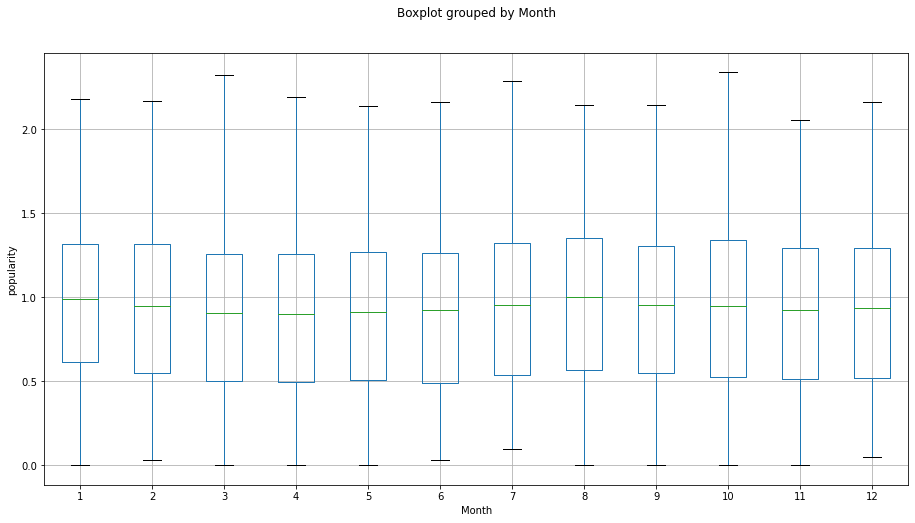

In [547]:
boxplot(filtered_videos_df, 'popularity', group_by='Month', samp_size=10000)

<AxesSubplot:title={'center':'Средняя популярность видео по дням недели'}, xlabel='dayofweek'>

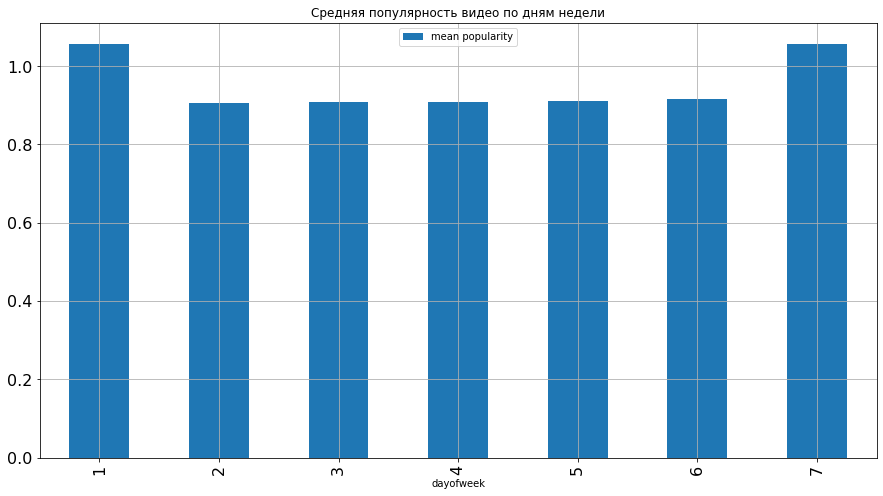

In [534]:
data_to_plot = (filtered_videos_df
                .groupby('dayofweek')
                .agg(F.mean('popularity').name('mean popularity'))
                .select('dayofweek', 'mean popularity')
                .orderBy("dayofweek", ascending=True)
                .toPandas())
data_to_plot.plot.bar(x="dayofweek", y="mean popularity", figsize=(15,10), title='Средняя популярность видео по дням недели', lw=3, fontsize=16, grid=True)

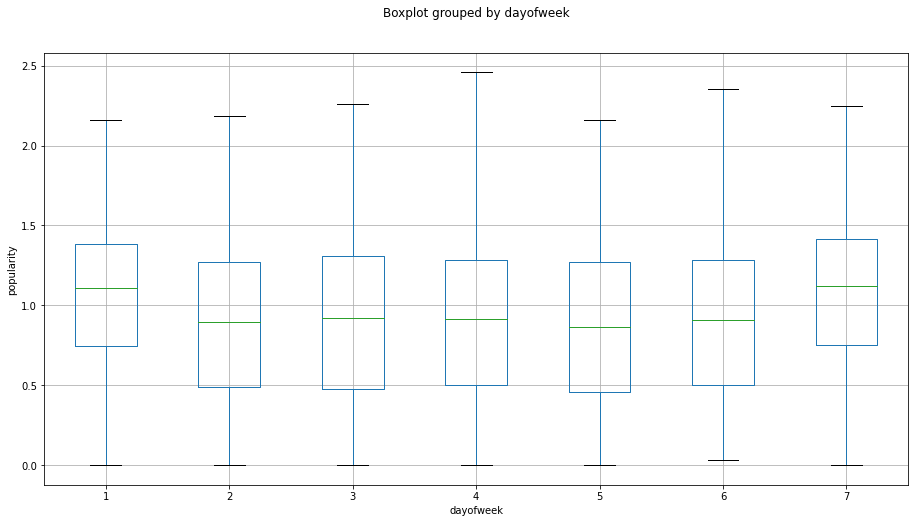

In [548]:
boxplot(filtered_videos_df, 'popularity', group_by='dayofweek', samp_size=10000)

<AxesSubplot:title={'center':'Средняя популярность видео по часу публикации'}, xlabel='hour'>

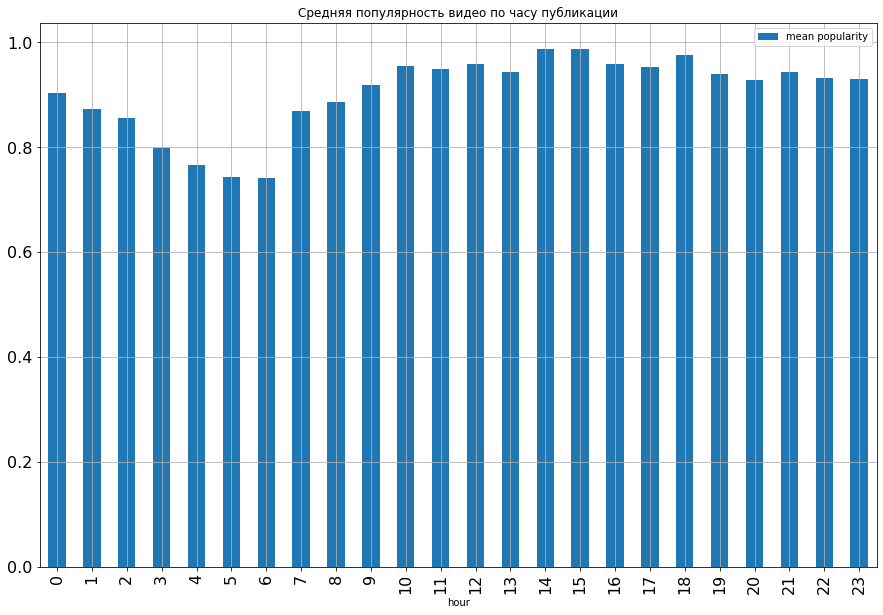

In [36]:
data_to_plot = (filtered_videos_df
                .groupby('hour')
                .agg(F.mean('popularity').name('mean popularity'))
                .select('hour', 'mean popularity')
                .orderBy("hour", ascending=True)
                .toPandas())
data_to_plot.plot.bar(x="hour", y="mean popularity", figsize=(15,10), title='Средняя популярность видео по часу публикации', lw=3, fontsize=16, grid=True)

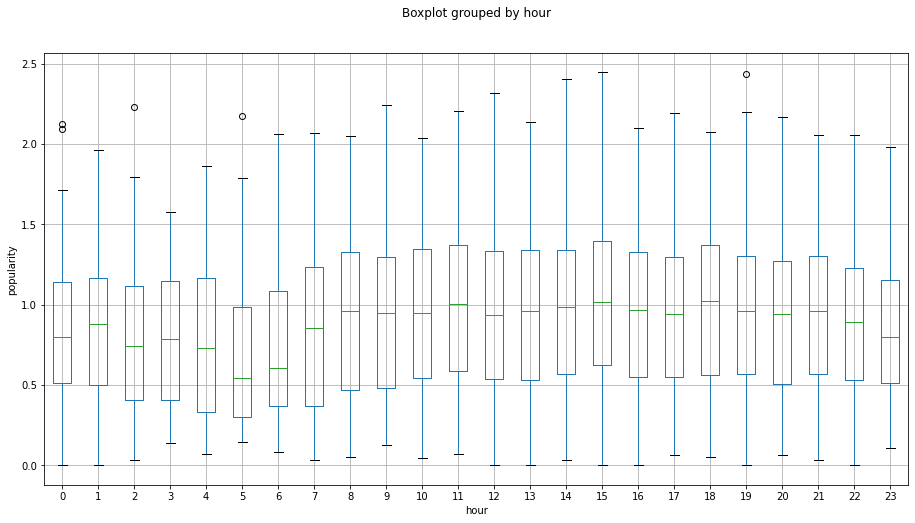

In [41]:
boxplot(filtered_videos_df, 'popularity', group_by='hour', samp_size=10000)

In [134]:
filtered_videos_df = filtered_videos_df.drop('views', 'likes', 'commentCount', 'log_views', 'log_likes', 'log_commentCount')

In [43]:
filtered_videos_df.printSchema()

root
 |-- ChannelId: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Published_date: timestamp (nullable = true)
 |-- Thumbnails: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- caption: boolean (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- definition: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- licensedContent: boolean (nullable = true)
 |-- status: boolean (nullable = true)
 |-- tags: string (nullable = true)
 |-- log_views_Scaled: double (nullable = true)
 |-- log_likes_Scaled: double (nullable = true)
 |-- log_commentCount_Scaled: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- hour: integer (nullable = true)



## Category and popularity


1   Film & Animation

2	Autos & Vehicles

10	Music

15	Pets & Animals

17	Sports

18	Short Movies

19	Travel & Events

20	Gaming

22	People & Blogs

23	Comedy

24	Entertainment

25	News & Politics

26	Howto & Style

27	Education

28	Science & Technology

29	Nonprofits & Activism

In [564]:
category_mapping = {1: 'Film & Animation', 
                    2: 'Autos & Vehicles', 
                    10: 'Music', 
                    15: 'Pets & Animals', 
                    17: 'Sports', 
                    18: 'Short Movies', 
                    19: 'Travel & Events', 
                    20: 'Gaming', 
                    22: 'People & Blogs', 
                    23: 'Comedy', 
                    24: 'Entertainment', 
                    25: 'News & Politics',
                    26: 'Howto & Style',
                    27: 'Education',
                    28: 'Science & Technology',
                    29: 'Nonprofits & Activism'}

<AxesSubplot:title={'center':'Средняя популярность видео по категориям'}, xlabel='CategoryID'>

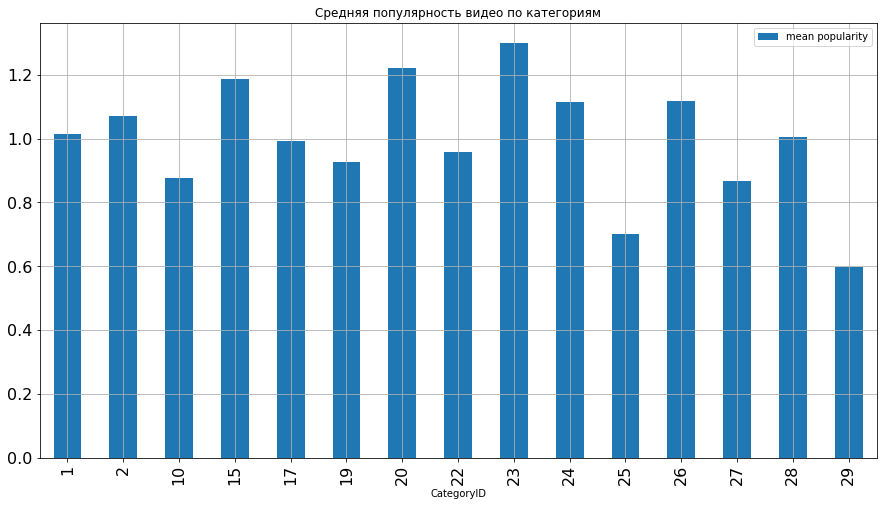

In [552]:
data_to_plot = (filtered_videos_df
                .groupby('CategoryID')
                .agg(F.mean('popularity').name('mean popularity'))
                .select('CategoryID', 'mean popularity')
                .orderBy('CategoryID', ascending=True)
                .toPandas())
data_to_plot.plot.bar(x='CategoryID', y="mean popularity", figsize=(15,8), title='Средняя популярность видео по категориям', lw=3, fontsize=16, grid=True)

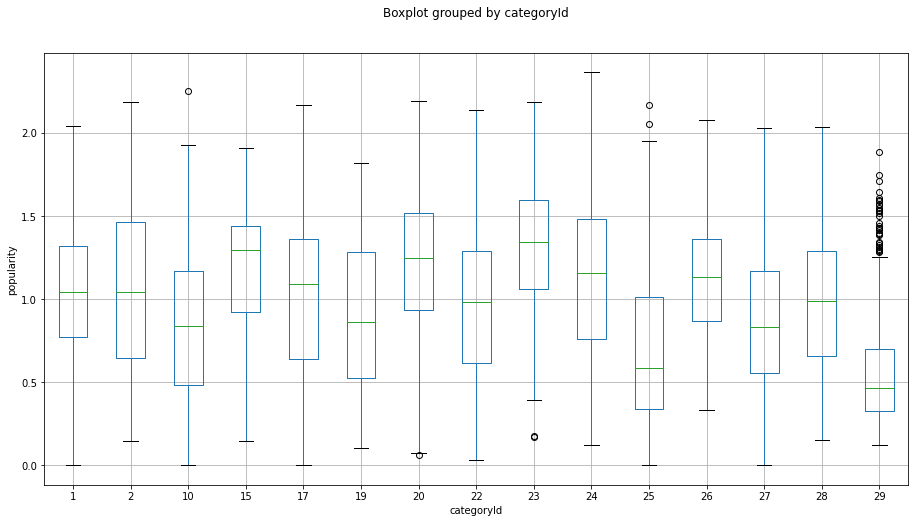

In [579]:
samp_size=10000
true_samp_size = min(samp_size/filtered_videos_df.count(), 1.0)
pd_df = filtered_videos_df.sample(False, true_samp_size).toPandas()

# Making plot 
pd_df.boxplot('popularity', by='categoryId', figsize=(15, 8))
plt.ylabel('popularity')
plt.title(None)
plt.show()

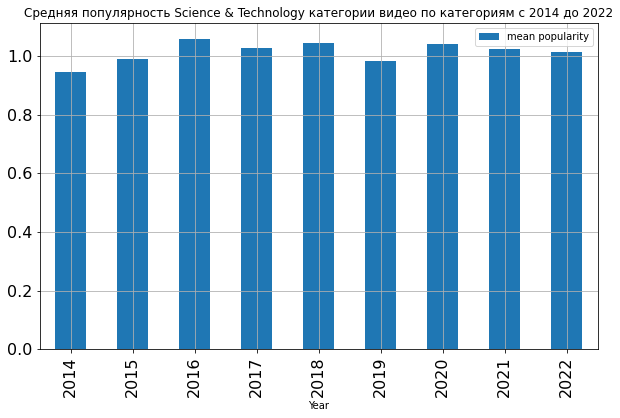

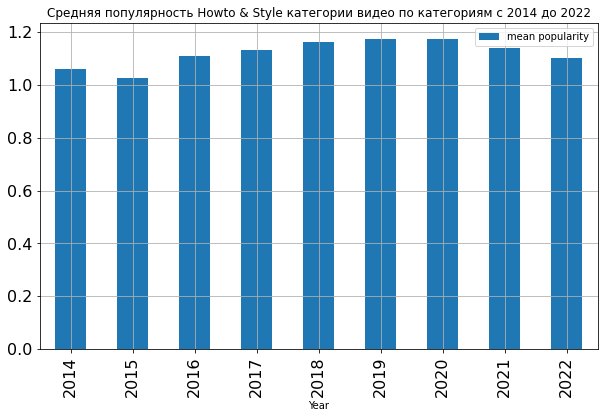

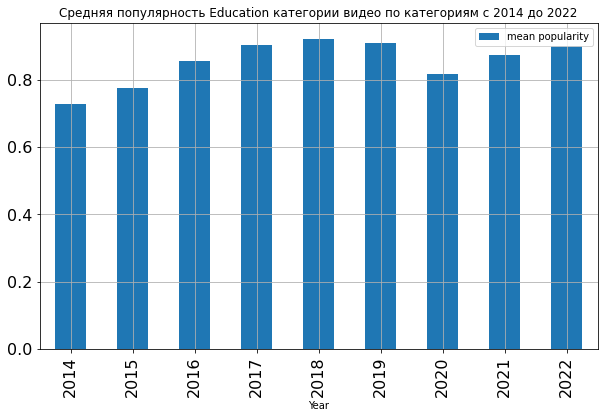

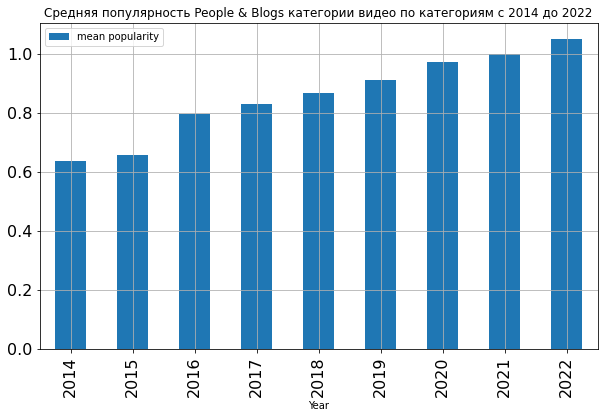

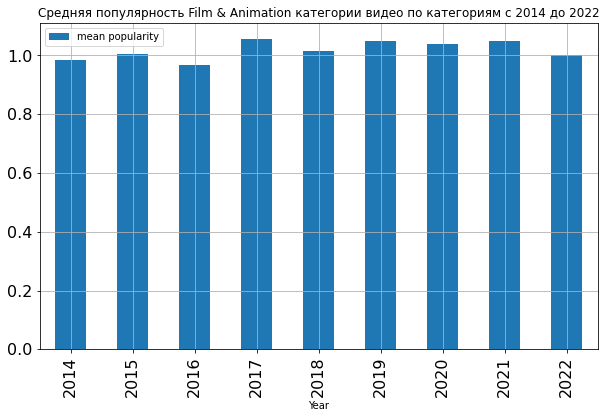

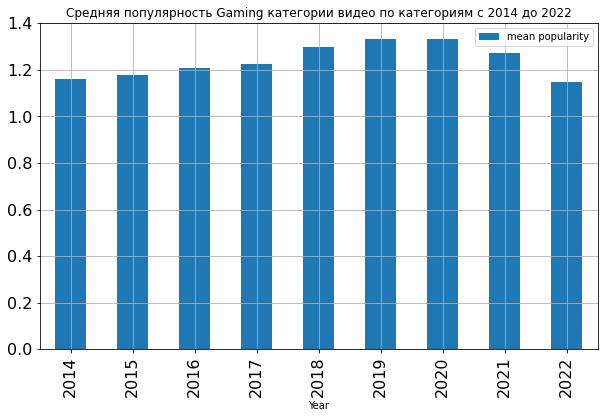

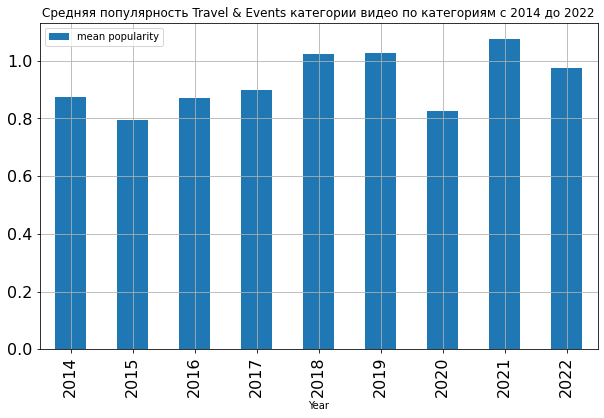

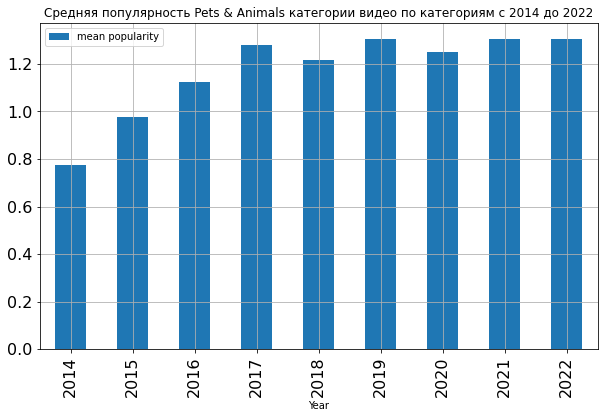

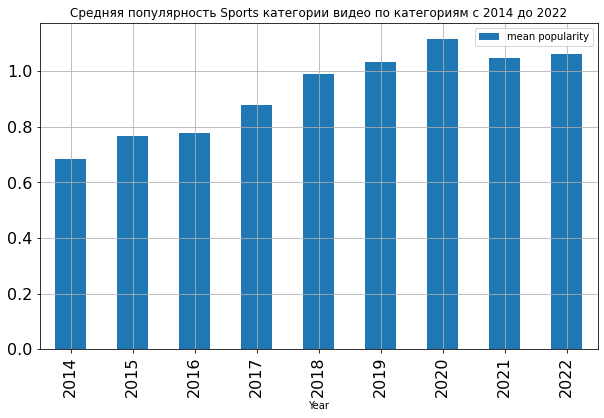

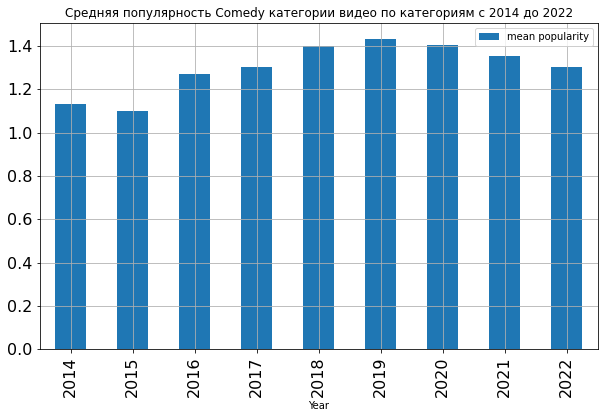

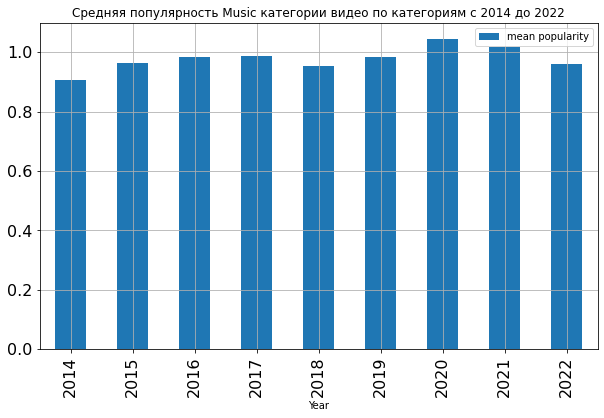

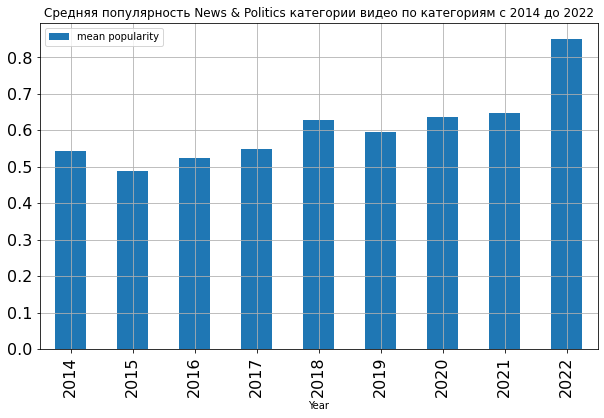

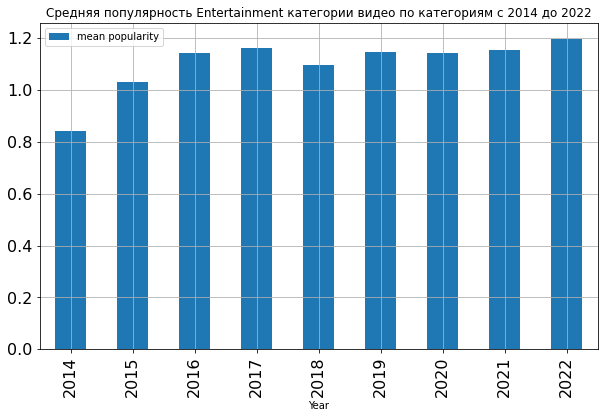

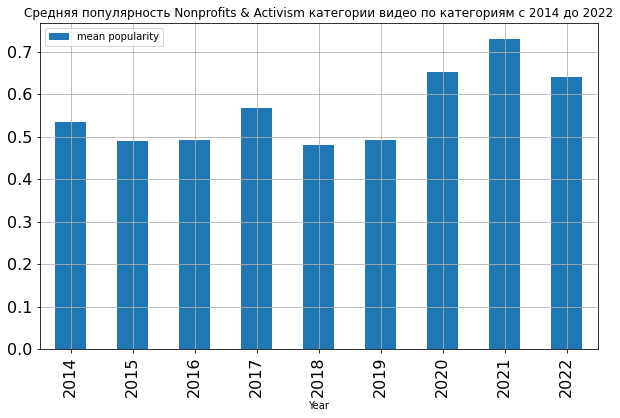

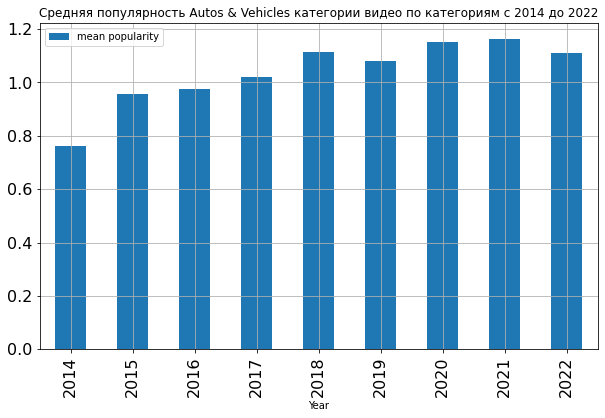

In [581]:
import matplotlib.pyplot as plt
for category in [i.categoryId for i in filtered_videos_df.select('categoryId').distinct().collect()]:
    
    data_to_plot = (filtered_videos_df
                    .where(F.col("categoryId") == category)
                    .where(F.col("Year") < 2023)
                    .where(F.col("Year") >= 2014)
                    .groupby('Year')
                    .agg(F.mean('popularity').name('mean popularity'))
                    .select('Year', 'mean popularity')
                    .orderBy('Year', ascending=True)
                    .toPandas())
    data_to_plot.plot.bar(x='Year', y="mean popularity", figsize=(10, 6), title=f'Средняя популярность категории {category_mapping[category]} c 2014 до 2022' ,lw=3, fontsize=16, grid=True)
    plt.show()

## Duration and popularity

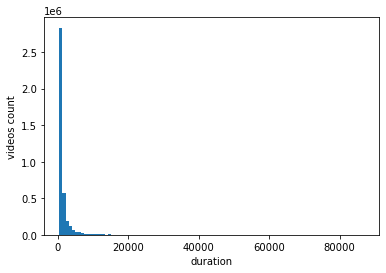

In [584]:
histogram(filtered_videos_df, 'duration', xname='duration', yname='videos count')

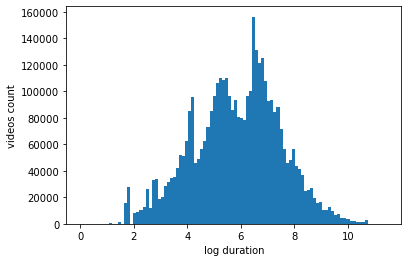

In [585]:
histogram(filtered_videos_df, F.log('duration'), xname='log duration', yname='videos count')

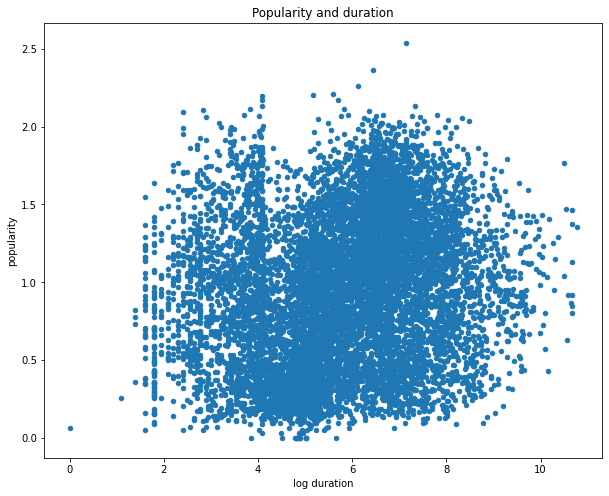

In [586]:
samp_size=10000
true_samp_size = min(samp_size/filtered_videos_df.count(), 1.0)
pd_df = filtered_videos_df.withColumn('log duration', F.log('duration')).sample(False, true_samp_size).toPandas()

pd_df.plot.scatter(x='log duration', y='popularity', figsize=(10, 8))
plt.ylabel('popularity')
plt.title('Popularity and duration')
plt.show()

In [135]:
filtered_videos_df = filtered_videos_df.withColumn('log_duration', F.log('duration'))

## Other non-text features

<AxesSubplot:title={'center':'Средняя популярность видео по наличию субтитров'}, xlabel='caption'>

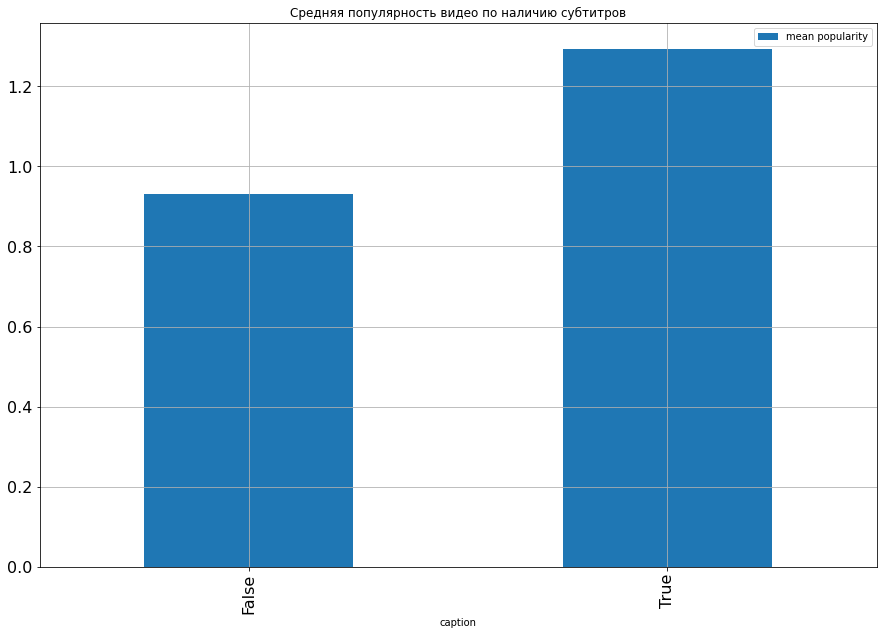

In [570]:
data_to_plot = (filtered_videos_df
                .groupby('caption')
                .agg(F.mean('popularity').name('mean popularity'))
                .select('caption', 'mean popularity')
                .orderBy("caption", ascending=True)
                .toPandas())
data_to_plot.plot.bar(x="caption", y="mean popularity", figsize=(15,10), title='Средняя популярность видео по наличию субтитров', lw=3, fontsize=16, grid=True)

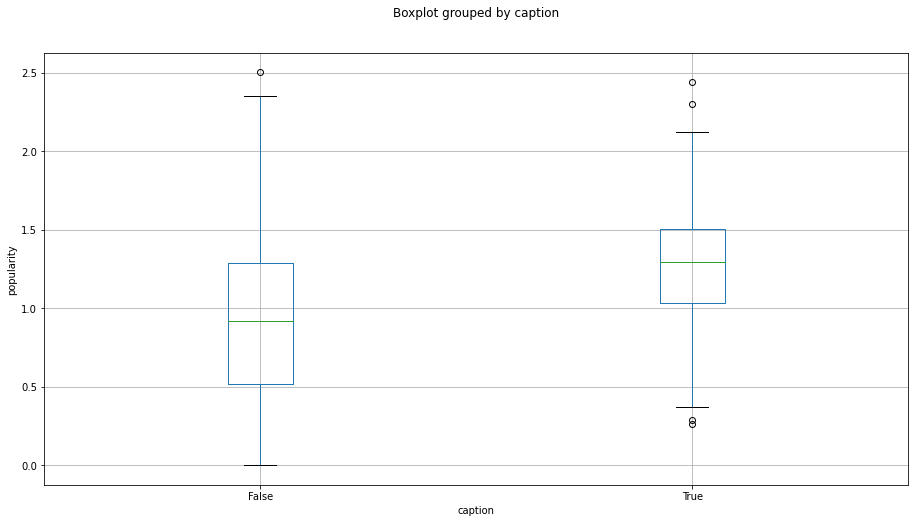

In [572]:
boxplot(filtered_videos_df, 'popularity', group_by='caption', samp_size=10000)

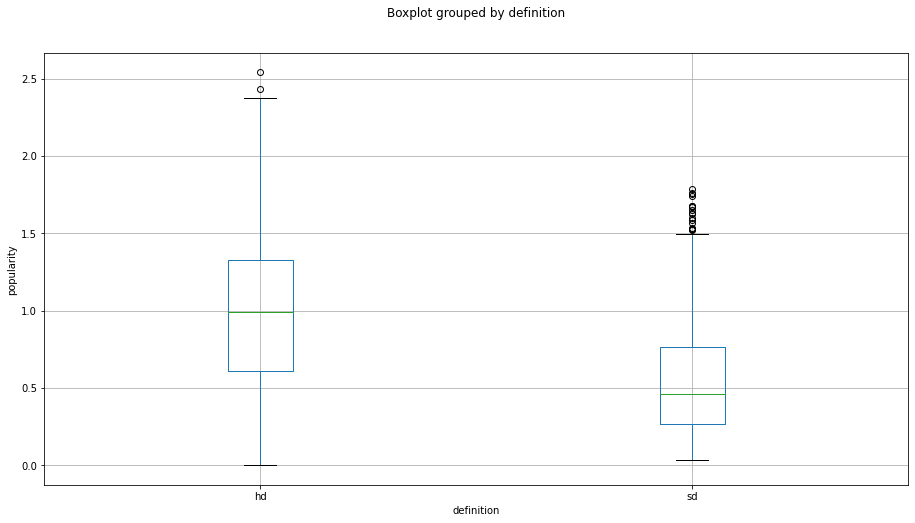

In [573]:
boxplot(filtered_videos_df, 'popularity', group_by='definition', samp_size=10000)

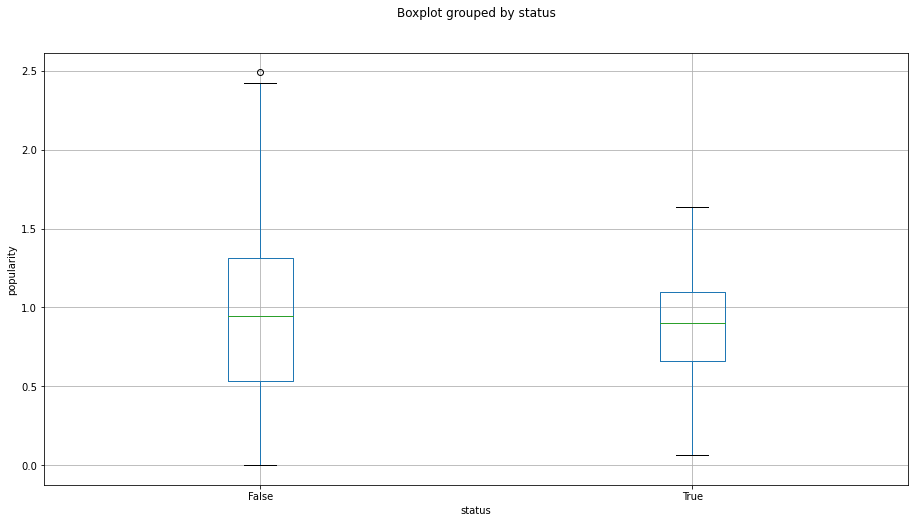

In [574]:
boxplot(filtered_videos_df, 'popularity', group_by='status', samp_size=10000)

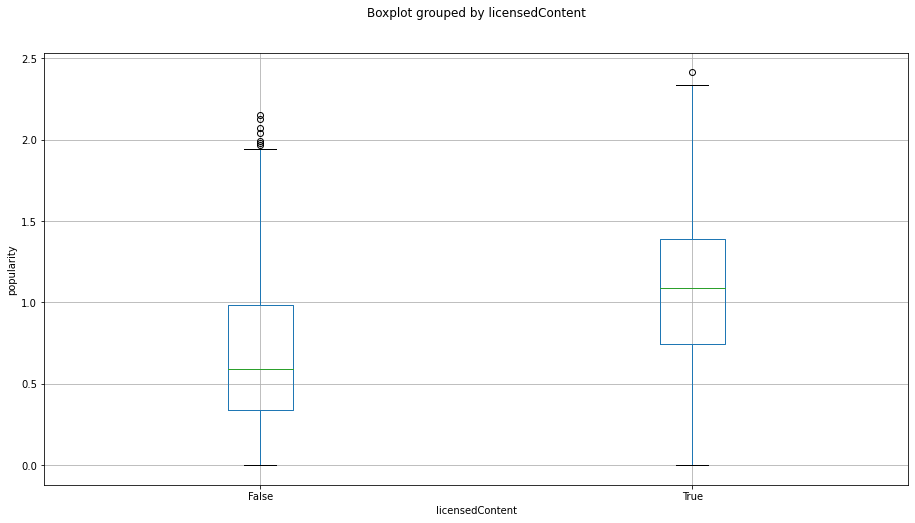

In [575]:
boxplot(filtered_videos_df, 'popularity', group_by='licensedContent', samp_size=10000)

## Text based features


### Tags and popularity

In [589]:
filtered_videos_df.where(F.col('tags')=='недоступно').count()

912205

In [136]:
filtered_videos_df = filtered_videos_df.withColumn('has_tags', F.col('tags') != 'недоступно')

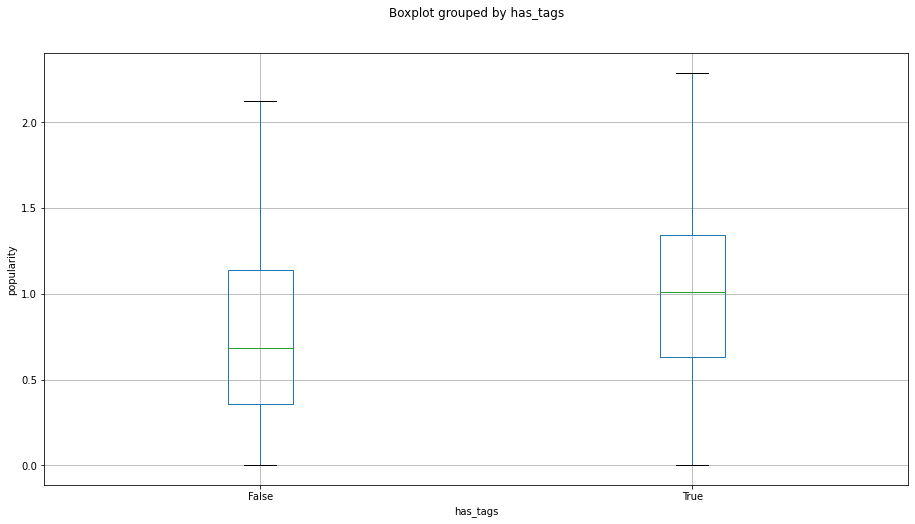

In [592]:
boxplot(filtered_videos_df, 'popularity', group_by='has_tags', samp_size=10000)

### Most popular tags

In [137]:
filtered_videos_df = filtered_videos_df.withColumn('proc_tags', F.lower(F.col('tags')))

In [138]:
filtered_videos_df = filtered_videos_df.withColumn('proc_tags', F.translate(F.col('proc_tags'), "[] '", ''))

In [674]:
filtered_videos_df.where(F.col('has_tags')=='true').select('proc_tags').show(100, truncate=False)

+-------------------------------------------------------------------------+
|proc_tags                                                                |
+-------------------------------------------------------------------------+
|#vivavideo                                                               |
|#vivavideo                                                               |
|#баня#сауна#парная#парилка                                               |
|#баня#сауна#парная                                                       |
|#баня#парилка#парная#сауна                                               |
|#собаки#кошки#ши-тцу#самаялучшая#животные,#ши-тцу                        |
|#собаки#кошки#самаяумая#щенки                                            |
|#vivavideo                                                               |
|#vivavideo                                                               |
|#vivavideo                                                               |
|#vivavideo 

In [139]:
filtered_videos_df = filtered_videos_df.withColumn('proc_tags', F.split(F.col('proc_tags'), ','))

In [140]:
tags_count = (filtered_videos_df
                  .where(F.col('has_tags') == 'true')
                  .select(F.explode('proc_tags').name('sep_tags'))
                  .groupby('sep_tags')
                  .count()
                  .orderBy('count', ascending=False)
                  .select('sep_tags', 'count')) 

tags_count.show(100, truncate=False)

+-----------------------+------+
|sep_tags               |count |
+-----------------------+------+
|новости                |412020|
|украина                |164905|
|россия                 |155342|
|войнавукраине          |96646 |
|news                   |89282 |
|обзор                  |84536 |
|новостиукраины         |81908 |
|политика               |78514 |
|путин                  |75390 |
|новини                 |69287 |
|юмор                   |63970 |
|приколы                |62395 |
|последниеновости       |57943 |
|кино                   |55744 |
|игры                   |54902 |
|новостисегодня         |54252 |
|видео                  |53718 |
|онлайн                 |51100 |
|беларусь               |49809 |
|интервью               |49793 |
|прохождение            |48941 |
|музыка                 |48690 |
|сша                    |48060 |
|бастыжаңалықтар        |47067 |
|спорт                  |46710 |
|майнкрафт              |46646 |
|топ                    |46505 |
|события  

In [679]:
tags_count.count()

5592636

In [141]:
top_tags = tags_count.where(F.col('count') >= 25000)

In [699]:
top_tags.count()

99

In [142]:
top_tags_list = top_tags.rdd.map(lambda x: x.sep_tags).collect()

In [701]:
(filtered_videos_df
 .withColumn("list", F.array([F.lit(i) for i in top_tags_list]))
 .withColumn("has_pop_tags", F.arrays_overlap(F.col('proc_tags'), F.col("list")))
 .drop("list")
 .where(F.col('has_tags') == 'true')
 .select('proc_tags', 'has_pop_tags').show(100))

+--------------------+------------+
|           proc_tags|has_pop_tags|
+--------------------+------------+
|        [#vivavideo]|       false|
|        [#vivavideo]|       false|
|[#баня#сауна#парн...|       false|
|[#баня#сауна#парная]|       false|
|[#баня#парилка#па...|       false|
|[#собаки#кошки#ши...|       false|
|[#собаки#кошки#са...|       false|
|        [#vivavideo]|       false|
|        [#vivavideo]|       false|
|        [#vivavideo]|       false|
|        [#vivavideo]|       false|
|        [#vivavideo]|       false|
|        [#vivavideo]|       false|
|        [#vivavideo]|       false|
|        [#vivavideo]|       false|
|        [#vivavideo]|       false|
|        [#vivavideo]|       false|
|        [#vivavideo]|       false|
|        [#vivavideo]|       false|
|        [#vivavideo]|       false|
|        [#vivavideo]|       false|
|        [#vivavideo]|       false|
|        [#vivavideo]|       false|
|        [#vivavideo]|       false|
|        [#vivavideo]|      

In [143]:
filtered_videos_df = (filtered_videos_df
 .withColumn("list", F.array([F.lit(i) for i in top_tags_list]))
 .withColumn("has_pop_tags", F.arrays_overlap(F.col('proc_tags'), F.col("list")))
 .drop("list"))

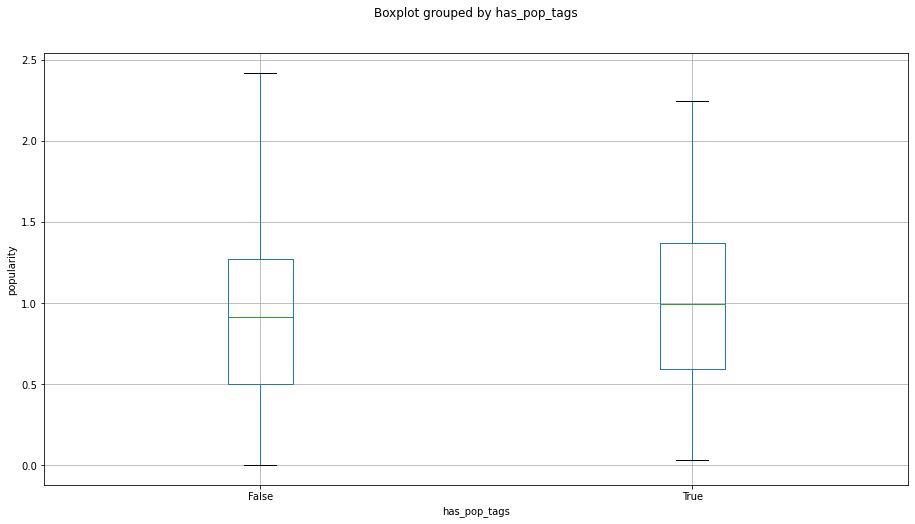

In [703]:
boxplot(filtered_videos_df, 'popularity', group_by='has_pop_tags', samp_size=10000)

## Title and populatity

In [144]:
filtered_videos_df = filtered_videos_df.where(F.col('Title').isNotNull())

In [145]:
filtered_videos_df = filtered_videos_df.withColumn('title_len', F.length('Title'))

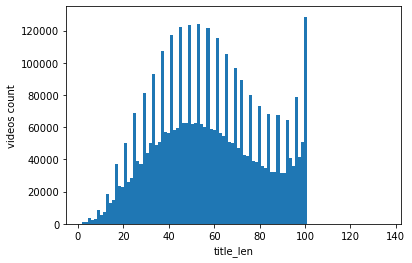

In [707]:
histogram(filtered_videos_df, 'title_len', xname='title_len', yname='videos count')

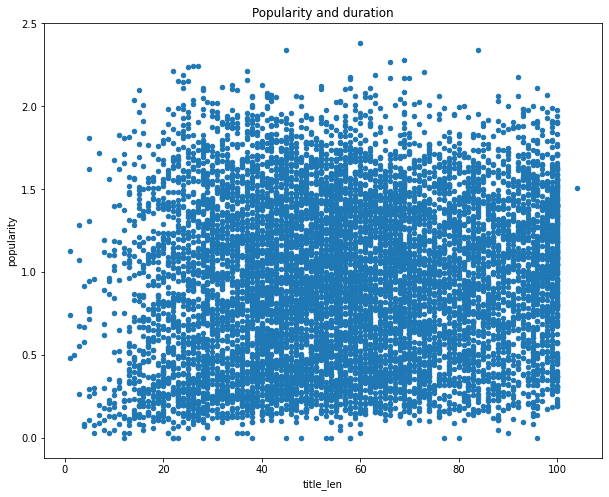

In [706]:
samp_size=10000
true_samp_size = min(samp_size/filtered_videos_df.count(), 1.0)
pd_df = filtered_videos_df.sample(False, true_samp_size).toPandas()

pd_df.plot.scatter(x='title_len', y='popularity', figsize=(10, 8))
plt.ylabel('popularity')
plt.title('Popularity and title length')
plt.show()

### Uppercase in titile

In [146]:
def title_is_uppercase(text):
    if not text:
        return None
    upper_prop = sum(map(str.isupper, text)) / len(text)
    return upper_prop >= 0.5

titleIsUpperCase = F.udf(title_is_uppercase, returnType=T.BooleanType())
filtered_videos_df = filtered_videos_df.withColumn('title_is_uppercase', titleIsUpperCase('Title'))
filtered_videos_df.select('Title', 'title_is_uppercase').show(20, truncate=False)               

+---------------------------------------------------------------------------------------------------+------------------+
|Title                                                                                              |title_is_uppercase|
+---------------------------------------------------------------------------------------------------+------------------+
|ГОТОВИМ КУРЯТНИК К НОВОЙ ПАРТИИ НЕСУШЕК !                                                          |true              |
|ПЕЧЬ ДЛЯ ПИЦЦЫ СВОИМИ РУКАМИ. Разборная. Переносная. "Помпейская печь"                             |false             |
|КУРЯТНИК МОЕЙ МЕЧТЫ                                                                                |true              |
|Приятная парная                                                                                    |false             |
|Приятная парная                                                                                    |false             |
|Приятная парная                

   title_is_uppercase  videos count
0               False       3387875
1                True        589961


<AxesSubplot:title={'center':'Количество видео c капсом в заголовке'}, xlabel='title_is_uppercase'>

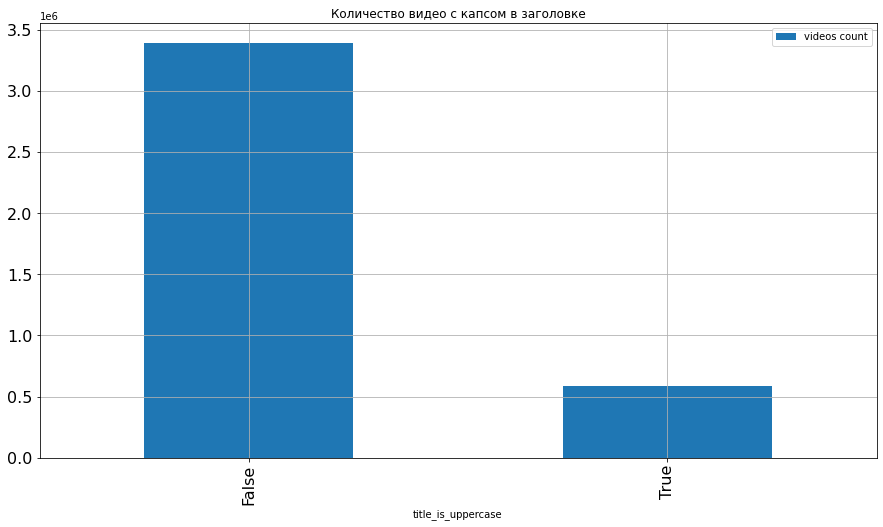

In [742]:
data_to_plot = (filtered_videos_df
                .groupby('title_is_uppercase')
                .agg(F.count('popularity').name('videos count'))
                .select('title_is_uppercase', 'videos count')
                .orderBy('title_is_uppercase', ascending=True)
                .toPandas())
print(data_to_plot)
data_to_plot.plot.bar(x='title_is_uppercase', y="videos count", figsize=(15,8), title='Количество видео c капсом в заголовке', lw=3, fontsize=16, grid=True)

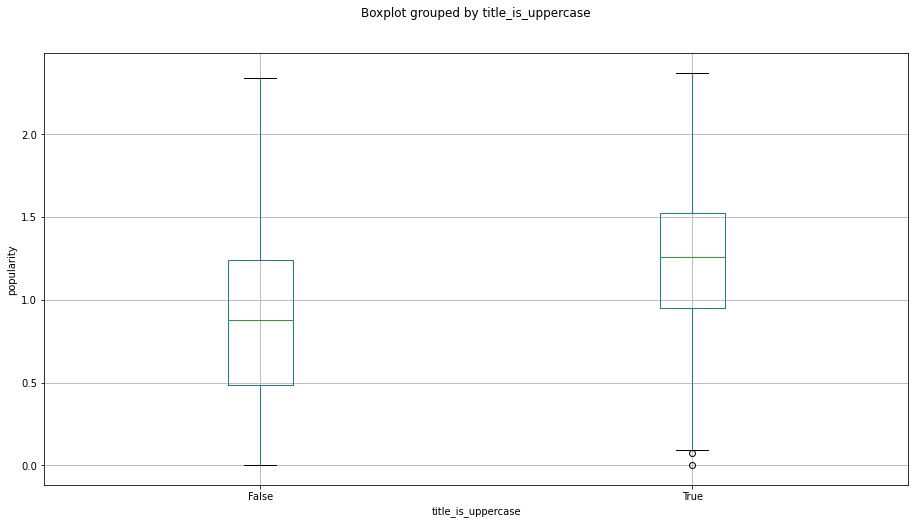

In [743]:
boxplot(filtered_videos_df, 'popularity', group_by='title_is_uppercase', samp_size=10000)

### Exclamation marks in title

In [147]:
def title_has_exclamation(text):
    if not text:
        return None
    has_excl = ('!' in text) or ('?' in text)
    return has_excl

exclamationDetector = F.udf(title_has_exclamation, returnType=T.BooleanType())
filtered_videos_df = filtered_videos_df.withColumn('title_has_excl', exclamationDetector('Title'))
filtered_videos_df.select('Title', 'title_has_excl').show(20, truncate=False) 

+---------------------------------------------------------------------------------------------------+--------------+
|Title                                                                                              |title_has_excl|
+---------------------------------------------------------------------------------------------------+--------------+
|ГОТОВИМ КУРЯТНИК К НОВОЙ ПАРТИИ НЕСУШЕК !                                                          |true          |
|ПЕЧЬ ДЛЯ ПИЦЦЫ СВОИМИ РУКАМИ. Разборная. Переносная. "Помпейская печь"                             |false         |
|КУРЯТНИК МОЕЙ МЕЧТЫ                                                                                |false         |
|Приятная парная                                                                                    |false         |
|Приятная парная                                                                                    |false         |
|Приятная парная                                                

   title_has_excl  videos count
0           False       3153097
1            True        824739


<AxesSubplot:title={'center':'Количество видео c ! или ? в заголовке'}, xlabel='title_has_excl'>

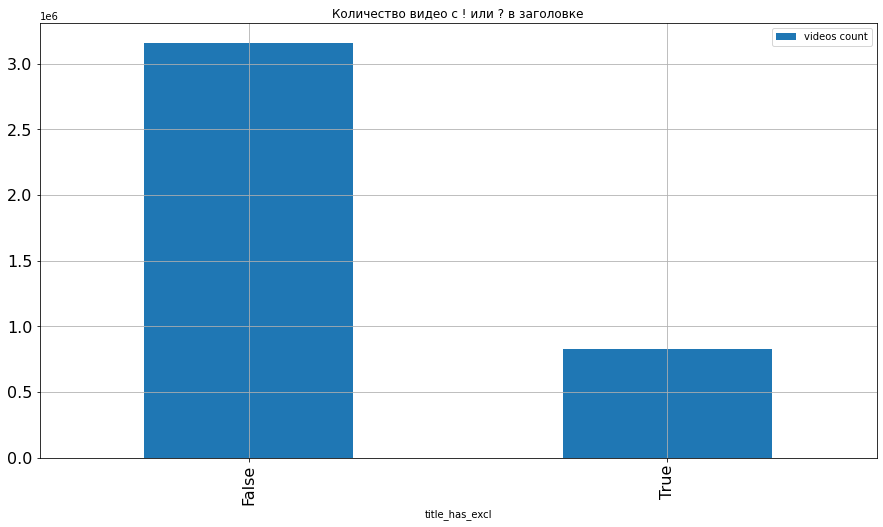

In [746]:
data_to_plot = (filtered_videos_df
                .groupby('title_has_excl')
                .agg(F.count('popularity').name('videos count'))
                .select('title_has_excl', 'videos count')
                .orderBy('title_has_excl', ascending=True)
                .toPandas()
               )
print(data_to_plot)
data_to_plot.plot.bar(x='title_has_excl', y="videos count", figsize=(15,8), title='Количество видео c ! или ? в заголовке', lw=3, fontsize=16, grid=True)

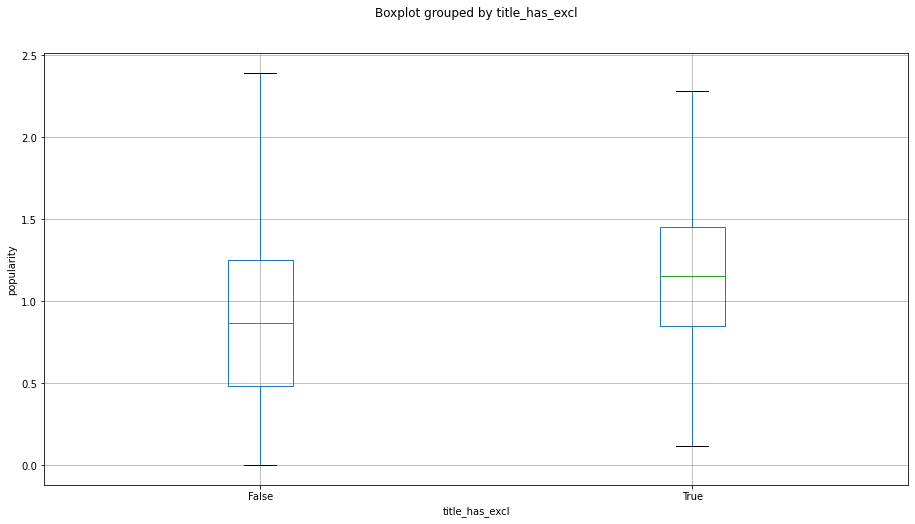

In [747]:
boxplot(filtered_videos_df, 'popularity', group_by='title_has_excl', samp_size=10000)

### Tags in title

In [148]:
def title_has_tags(text):
    if not text:
        return None
    has_tag = ('#' in text)
    return has_tag

tagsDetector = F.udf(title_has_tags, returnType=T.BooleanType())
filtered_videos_df = filtered_videos_df.withColumn('title_has_tags', tagsDetector('Title'))
filtered_videos_df.select('Title', 'title_has_tags').show(20, truncate=False) 

+---------------------------------------------------------------------------------------------------+--------------+
|Title                                                                                              |title_has_tags|
+---------------------------------------------------------------------------------------------------+--------------+
|ГОТОВИМ КУРЯТНИК К НОВОЙ ПАРТИИ НЕСУШЕК !                                                          |false         |
|ПЕЧЬ ДЛЯ ПИЦЦЫ СВОИМИ РУКАМИ. Разборная. Переносная. "Помпейская печь"                             |false         |
|КУРЯТНИК МОЕЙ МЕЧТЫ                                                                                |false         |
|Приятная парная                                                                                    |false         |
|Приятная парная                                                                                    |false         |
|Приятная парная                                                

   title_has_tags  videos count
0           False       3583867
1            True        393969


<AxesSubplot:title={'center':'Количество видео c хештегом в заголовке'}, xlabel='title_has_tags'>

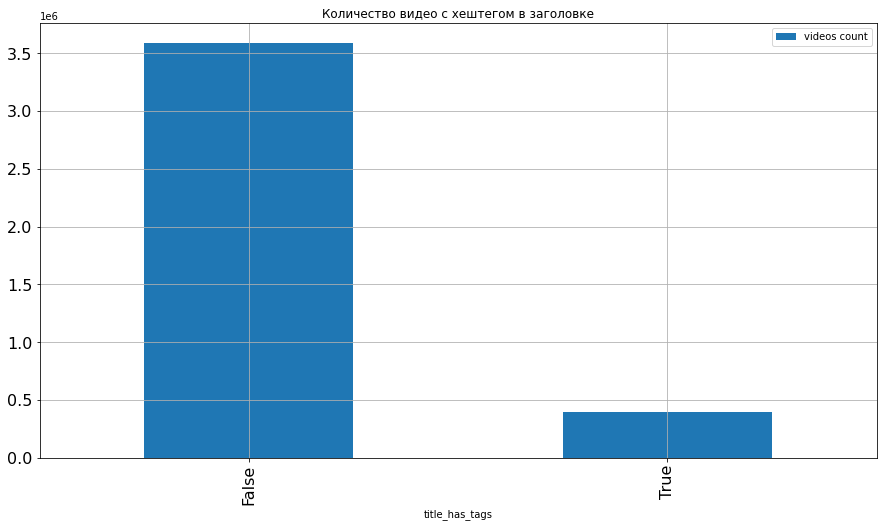

In [776]:
data_to_plot = (filtered_videos_df
                .groupby('title_has_tags')
                .agg(F.count('popularity').name('videos count'))
                .select('title_has_tags', 'videos count')
                .orderBy('title_has_tags', ascending=True)
                .toPandas()
               )
print(data_to_plot)
data_to_plot.plot.bar(x='title_has_tags', y="videos count", figsize=(15,8), title='Количество видео c хештегом в заголовке', lw=3, fontsize=16, grid=True)

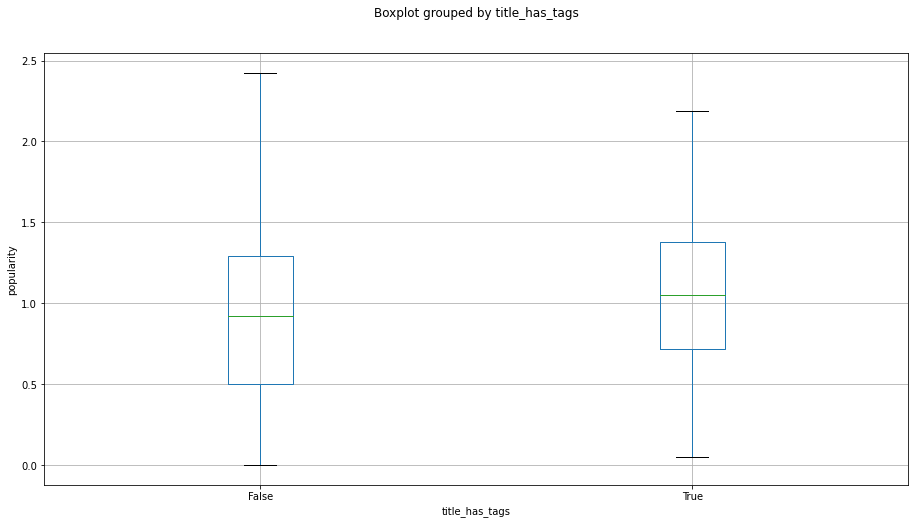

In [777]:
boxplot(filtered_videos_df, 'popularity', group_by='title_has_tags', samp_size=10000)

### Emoji in titles

In [149]:
with open("/home/jovyan/shared-data/bigdata20/emojis_sentiment.json", "r") as f:
    emojis_sentiment_dict = json.loads(f.read())

In [155]:

def emo_from_text(text):
    if not text:
        return None
    emo_list = [d['emoji'] for d in emoji.emoji_lis(text)]  
    return emo_list

def get_sentiment(emo):
    return broadcasted_variable.value.get(emo)



textToEmojis = F.udf(emo_from_text, returnType=T.ArrayType(T.StringType()))

In [58]:
import emoji
    
broadcasted_variable = spark.sparkContext.broadcast(emojis_sentiment_dict)

emojis_count = (filtered_videos_df
                  .select(F.explode(textToEmojis('Title')).name('emoji'))
                  .groupby('emoji')
                  .count()
                  .orderBy('count', ascending=False)
                  .select('emoji', 'count')) 

columns = ["emoji", "count", "sentiment"]
emojis_count = emojis_count.rdd.map(lambda x: (x[0], x[1], get_sentiment(x[0]))).toDF(columns)

positive_emojis = emojis_count.where(F.col('sentiment') == 'positive').select('emoji', 'count')

neutral_emojis = emojis_count.where(F.col('sentiment') == 'neutral').select('emoji', 'count')

negative_emojis = emojis_count.where(F.col('sentiment') == 'negative').select('emoji', 'count')

NameError: name 'emojis_sentiment_dict' is not defined

In [714]:
positive_emojis.show(20)
neutral_emojis.show(20)
negative_emojis.show(20)

+-----+-----+
|emoji|count|
+-----+-----+
|   😱|23104|
|    ❤|19271|
|   😂|18084|
|   🌴|16324|
|    ♥|15469|
|    ✅|10388|
|   😍| 9984|
|   👍| 7345|
|   😳| 5840|
|   😎| 5190|
|   🔔| 4180|
|   😅| 4164|
|   🎄| 4135|
|   😁| 3750|
|    ♦| 3657|
|   🎁| 3396|
|    ❄| 3361|
|    ⭐| 3005|
|   💪| 2960|
|   💯| 2832|
+-----+-----+
only showing top 20 rows

+-----+-----+
|emoji|count|
+-----+-----+
|   🔥|45520|
|    ⚡|15323|
|   💥|14793|
|    ❗|10824|
|   🔴|10358|
|    ✨| 5077|
|    ❓| 4264|
|   🌟| 2655|
|   🌿| 2493|
|    ✔| 2381|
|   👉| 2277|
|    ▶| 2182|
|   👀| 1663|
|    ®| 1301|
|   💣| 1276|
|   💠| 1267|
|    ♠| 1221|
|   💰|  998|
|   🚦|  979|
|   🎬|  956|
+-----+-----+
only showing top 20 rows

+-----+-----+
|emoji|count|
+-----+-----+
|   😨| 2314|
|   😭| 2306|
|   😲| 2210|
|   😡| 1705|
|   💔| 1696|
|   😷| 1188|
|   😰| 1138|
|   💀|  960|
|   💩|  700|
|   😔|  603|
|   📌|  546|
|   😤|  439|
|   👿|  242|
|   🚫|  238|
|   😩|  225|
|   😧|  221|
|   💧|  221|
|   😪|  199|
|   😴|  193|
|   🔫|  176|


In [156]:
filtered_videos_df = (filtered_videos_df.withColumn('emoji_in_title', F.size(textToEmojis('Title')) != 0)) 

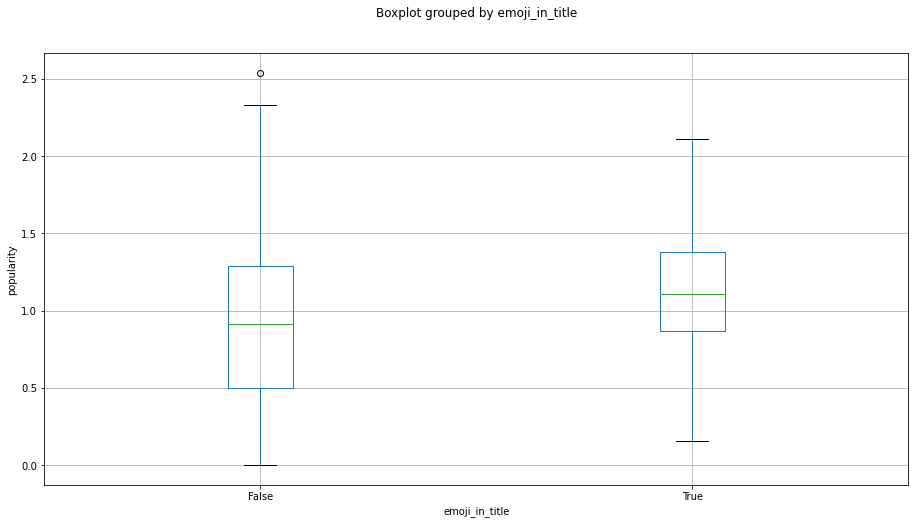

In [157]:
boxplot(filtered_videos_df, 'popularity', group_by='emoji_in_title', samp_size=10000)

### Emoji sentiment

In [768]:
emojis_sentiment_dict['😂']

'positive'

In [771]:
from collections import Counter

def emo_sentiment(text):
    emo_list = [d['emoji'] for d in emoji.emoji_lis(text)]  
    if not emo_list:
        return 'no emoji'        
    emo_sentiment_list = [emojis_sentiment_dict[str(emo)] for emo in emo_list if emo in emojis_sentiment_dict]
    if emo_sentiment_list:
        data = Counter(emo_sentiment_list)
        return max(emo_sentiment_list, key=data.get) 
    else:
        return 'no emoji'

emoSentiment = F.udf(emo_sentiment, returnType=T.StringType())
df = filtered_videos_df.withColumn('title_emoji_sentiment', emoSentiment('Title'))
df.where(F.col('title_emoji_sentiment') != 'no emoji').select('Title', 'title_emoji_sentiment').show(20, truncate=False) 

+-----------------------------------------------------------------------------------------------------+---------------------+
|Title                                                                                                |title_emoji_sentiment|
+-----------------------------------------------------------------------------------------------------+---------------------+
|После этого ДЕСЕРТА СВЕКРОВЬ ПОЛЮБИЛА МЕНЯ!❤ БЕЗ МУКИ! БЕЗ САХАРА! AZIZA GOTOVIT                     |positive             |
|Пирог за 5 минут! С ягодами! Полный рецепт у меня на канале! Заходите в гости❤                       |positive             |
|КОРОЛЕВСКИЙ САЛАТ❤"ГОСТИ В ШОКЕ ИЗ ЧЕГО ЖЕ ОН! А ВКУСНЫЙ КАКОЙ! ВЕК ЖИВИ ВЕК УЧИСЬ                   |positive             |
|Лучшее блюдо на праздничный стол! ОБАЛДЕННО ВКУСНО 👍ЛЮЛЯ КЕБАБ НА СКОВОРОДЕ. Вкуснее не ела!        |positive             |
|Научил турецкий повар! Я не думала что это так просто! НЕВЕРОЯТНО вкусно 😋                          |positive         

  title_emoji_sentiment  videos count
0              negative         15335
1               neutral        100890
2              no emoji       3663993
3              positive        197618


<AxesSubplot:title={'center':'Количество видео сентименту емоджи в заголовке'}, xlabel='title_emoji_sentiment'>

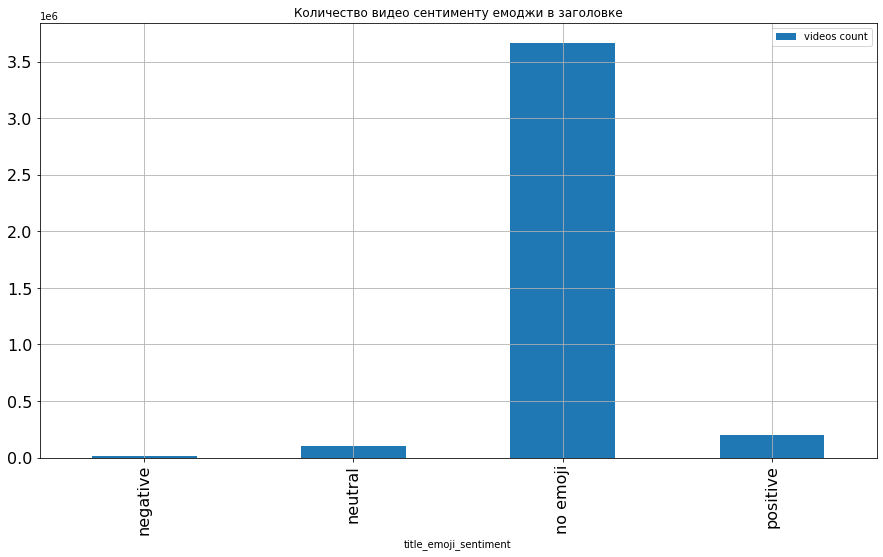

In [772]:
data_to_plot = (df
                .groupby('title_emoji_sentiment')
                .agg(F.count('popularity').name('videos count'))
                .select('title_emoji_sentiment', 'videos count')
                .orderBy('title_emoji_sentiment', ascending=True)
                .toPandas()
               )
print(data_to_plot)
data_to_plot.plot.bar(x='title_emoji_sentiment', y="videos count", figsize=(15,8), title='Количество видео сентименту емоджи в заголовке', lw=3, fontsize=16, grid=True)

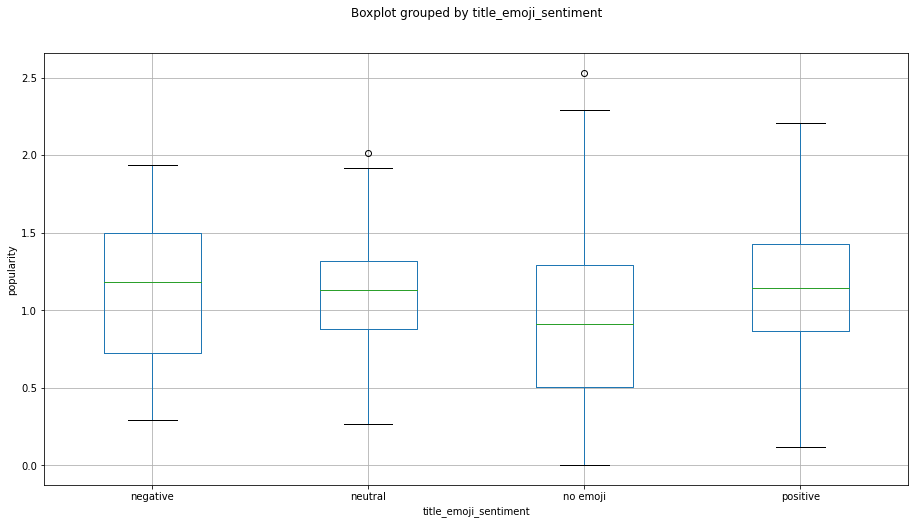

In [774]:
boxplot(df, 'popularity', group_by='title_emoji_sentiment', samp_size=10000)

### Description and popularity

In [787]:
filtered_videos_df.where(F.col('Description').isNull()).count()

504601

In [158]:
filtered_videos_df = filtered_videos_df.withColumn('has_description', F.col('Description').isNotNull())

   has_description  videos count
0            False        504601
1             True       3473235


<AxesSubplot:title={'center':'Количество видео с описанием и без'}, xlabel='has_description'>

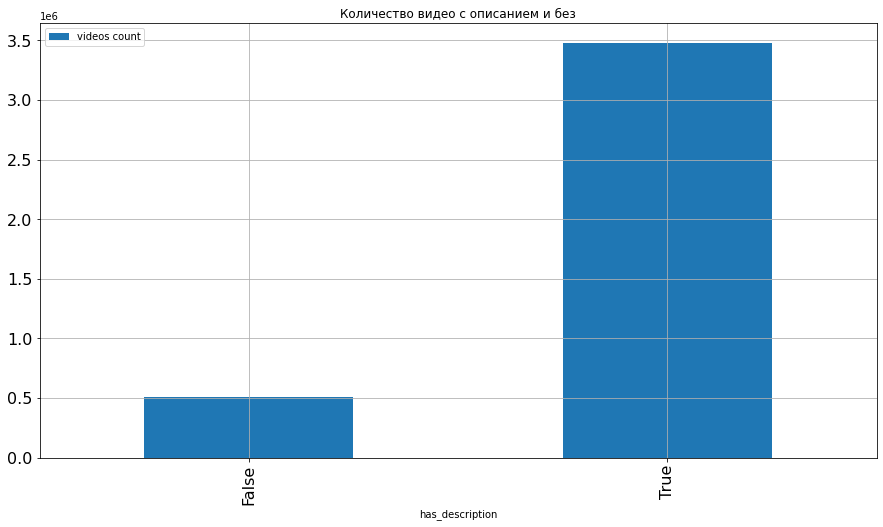

In [790]:
data_to_plot = (filtered_videos_df
                .groupby('has_description')
                .agg(F.count('popularity').name('videos count'))
                .select('has_description', 'videos count')
                .orderBy('has_description')
                .toPandas()
               )
print(data_to_plot)
data_to_plot.plot.bar(x='has_description', y="videos count", figsize=(15,8), title='Количество видео с описанием и без', lw=3, fontsize=16, grid=True)

   has_description  mean popularity
0            False         0.773333
1             True         0.965615


<AxesSubplot:title={'center':'Средняя популярность видео с описанием и без'}, xlabel='has_description'>

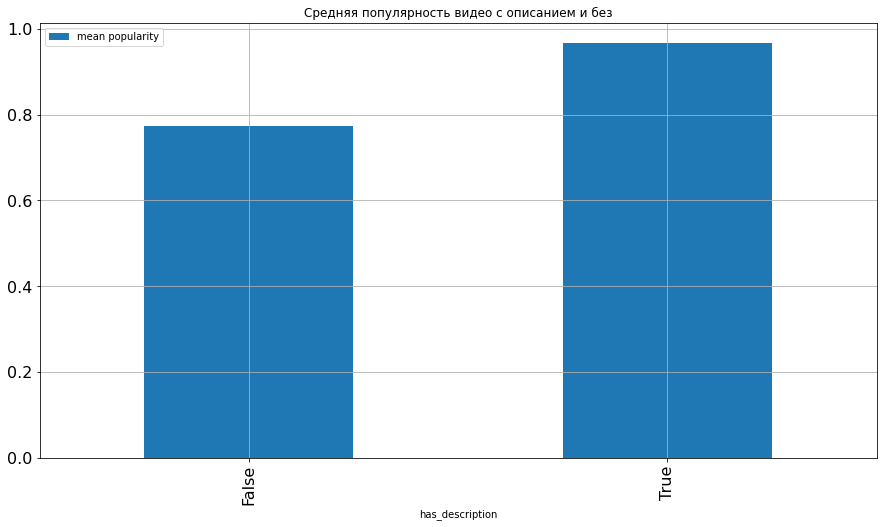

In [794]:
data_to_plot = (filtered_videos_df
                .groupby('has_description')
                .agg(F.mean('popularity').name('mean popularity'))
                .select('has_description', 'mean popularity')
                .orderBy('has_description')
                .toPandas()
               )
print(data_to_plot)
data_to_plot.plot.bar(x='has_description', y='mean popularity', figsize=(15,8), title='Средняя популярность видео с описанием и без', lw=3, fontsize=16, grid=True)

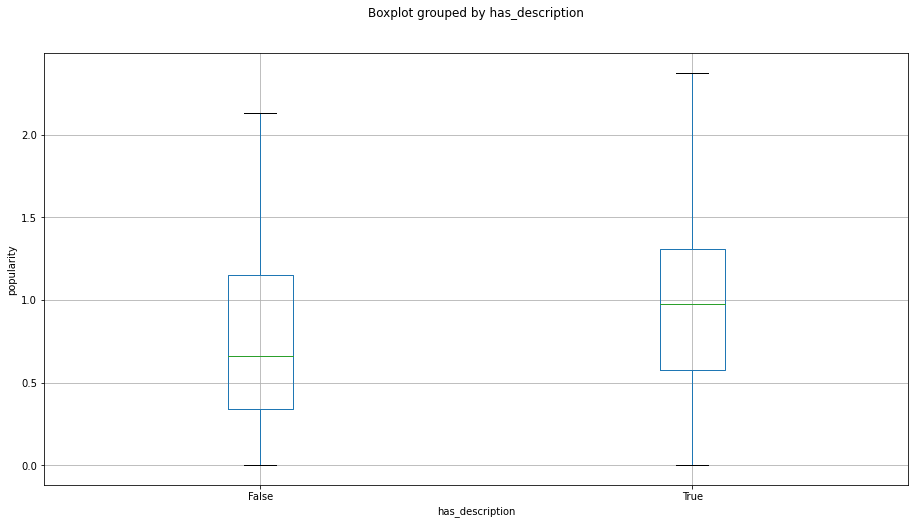

In [792]:
boxplot(filtered_videos_df, 'popularity', group_by='has_description', samp_size=10000)

In [153]:
filtered_videos_df = filtered_videos_df.na.fill(value='',subset=["Description"])

### Description length and popularity

In [159]:
filtered_videos_df = filtered_videos_df.withColumn('description_len', F.length('Description'))

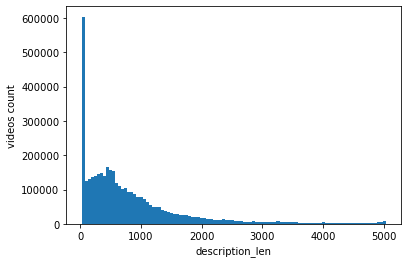

In [796]:
histogram(filtered_videos_df, 'description_len', xname='description_len', yname='videos count')

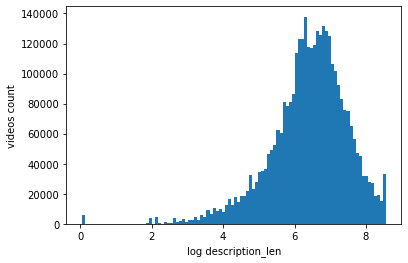

In [62]:
histogram(filtered_videos_df, F.log('description_len'), xname='log description_len', yname='videos count')

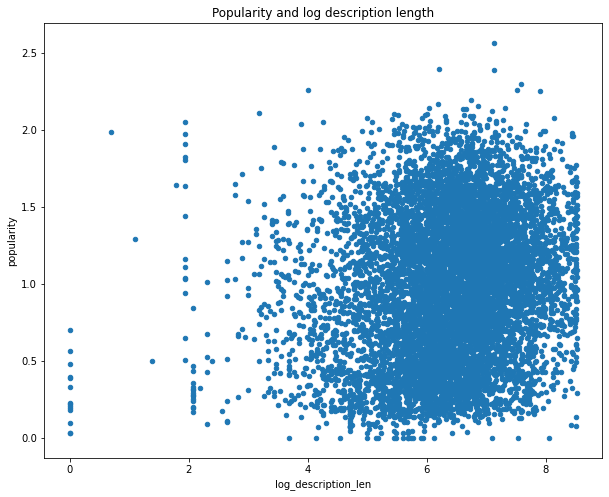

In [64]:
samp_size=10000
true_samp_size = min(samp_size/filtered_videos_df.count(), 1.0)
pd_df = filtered_videos_df.withColumn('log_description_len', F.log('description_len')).sample(False, true_samp_size).toPandas()

pd_df.plot.scatter(x='log_description_len', y='popularity', figsize=(10, 8))
plt.ylabel('popularity')
plt.title('Popularity and log description length')
plt.show()

In [160]:
filtered_videos_df = filtered_videos_df.withColumn('description_len', F.log('description_len'))

### Description contains tags

In [161]:
def description_has_tags(text):
    if not text:
        return False
    has_tag = ('#' in text)
    return has_tag

tagsDetector = F.udf(description_has_tags, returnType=T.BooleanType())
filtered_videos_df = filtered_videos_df.withColumn('description_has_tags', tagsDetector('Description'))
filtered_videos_df.select('Description', 'description_has_tags').show(20) 

+--------------------+--------------------+
|         Description|description_has_tags|
+--------------------+--------------------+
|Хотел купить крос...|               false|
|БЕЗ МЕТАЛЛА. БЕЗ ...|               false|
|Видео про поддоны...|                true|
|                    |               false|
|                    |               false|
|                    |               false|
|                    |               false|
|                    |               false|
|Отвечаю на вопрос...|                true|
|Продолжаю улучшат...|                true|
|Уже несколько лет...|               false|
|Переделал систему...|               false|
|Видео про мой бру...|               false|
|Простое приспособ...|                true|
|Первое видео про ...|               false|
|#Курятник#Несушки...|                true|
|Выращиваю птичек ...|               false|
|Мой канал в Яндек...|                true|
|Продолжаю дорабат...|                true|
|Видео для планиру...|          

   description_has_tags  videos count
0                 False       2595736
1                  True       1382100


<AxesSubplot:title={'center':'Количество видео c хештегами в описании'}, xlabel='description_has_tags'>

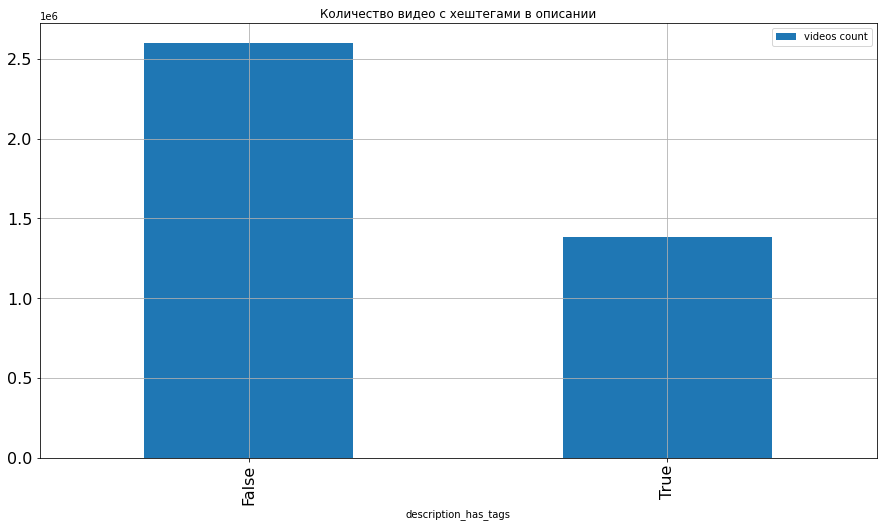

In [807]:
data_to_plot = (filtered_videos_df
                .groupby('description_has_tags')
                .agg(F.count('popularity').name('videos count'))
                .select('description_has_tags', 'videos count')
                .orderBy('description_has_tags', ascending=True)
                .toPandas()
               )
print(data_to_plot)
data_to_plot.plot.bar(x='description_has_tags', y="videos count", figsize=(15,8), title='Количество видео c хештегами в описании', lw=3, fontsize=16, grid=True)

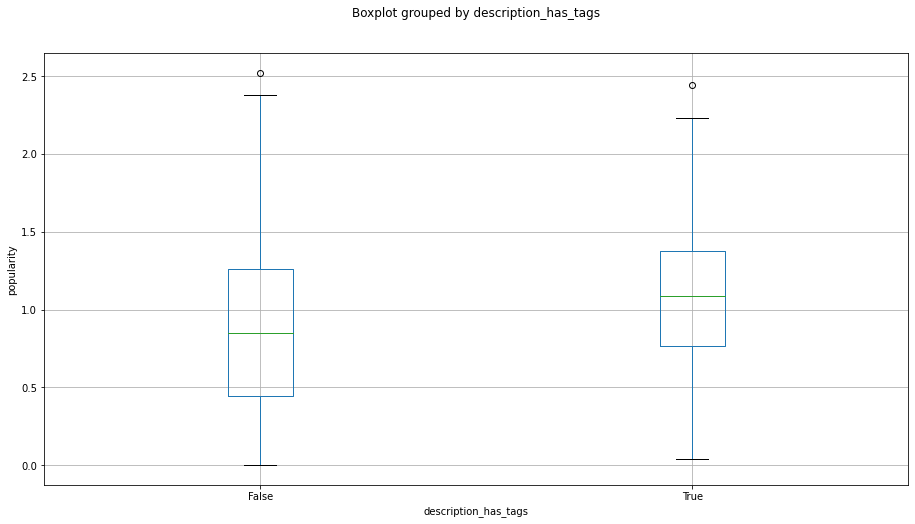

In [808]:
boxplot(filtered_videos_df, 'popularity', group_by='description_has_tags', samp_size=10000)

### Description contains links

In [162]:
import re

def description_has_links(text):
    if not text:
        return False
    links = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
    if links:
        return True
    else:
        return False

linksDetector = F.udf(description_has_links, returnType=T.BooleanType())
filtered_videos_df = filtered_videos_df.withColumn('description_has_links', linksDetector('Description'))
filtered_videos_df.select('Description', 'description_has_links').show(20) 

+--------------------+---------------------+
|         Description|description_has_links|
+--------------------+---------------------+
|Хотел купить крос...|                false|
|БЕЗ МЕТАЛЛА. БЕЗ ...|                false|
|Видео про поддоны...|                 true|
|                    |                false|
|                    |                false|
|                    |                false|
|                    |                false|
|                    |                false|
|Отвечаю на вопрос...|                false|
|Продолжаю улучшат...|                 true|
|Уже несколько лет...|                false|
|Переделал систему...|                 true|
|Видео про мой бру...|                 true|
|Простое приспособ...|                false|
|Первое видео про ...|                 true|
|#Курятник#Несушки...|                 true|
|Выращиваю птичек ...|                 true|
|Мой канал в Яндек...|                 true|
|Продолжаю дорабат...|                 true|
|Видео для

   description_has_links  videos count
0                  False       1235690
1                   True       2742146


<AxesSubplot:title={'center':'Количество видео со ссылками в описании'}, xlabel='description_has_links'>

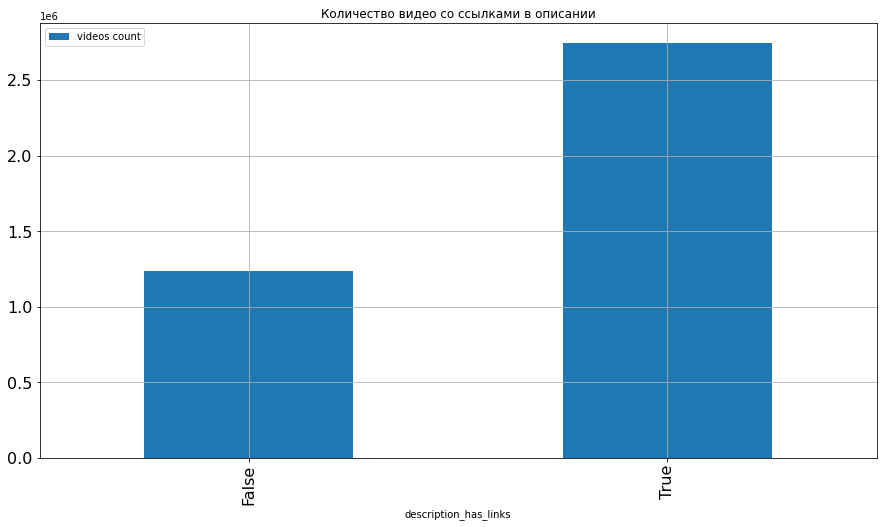

In [876]:
data_to_plot = (filtered_videos_df
                .groupby('description_has_links')
                .agg(F.count('popularity').name('videos count'))
                .select('description_has_links', 'videos count')
                .orderBy('description_has_links', ascending=True)
                .toPandas()
               )
print(data_to_plot)
data_to_plot.plot.bar(x='description_has_links', y="videos count", figsize=(15,8), title='Количество видео со ссылками в описании', lw=3, fontsize=16, grid=True)

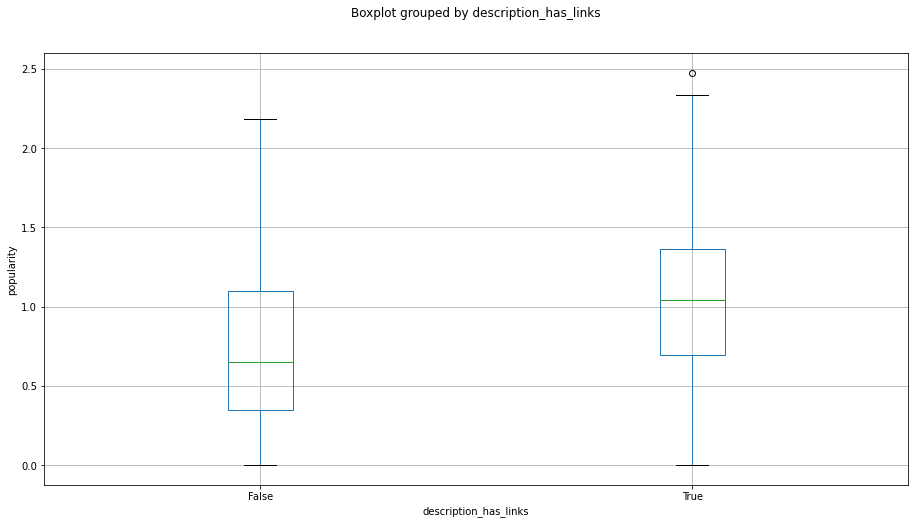

In [877]:
boxplot(filtered_videos_df, 'popularity', group_by='description_has_links', samp_size=10000)

## Popularity and mean popularity of videos in last month

In [163]:
filtered_videos_df = filtered_videos_df.withColumn("id", F.monotonically_increasing_id())

In [164]:
test = (filtered_videos_df.alias("df1")
.join(filtered_videos_df.alias("df2"), F.col("df1.ChannelId") == F.col("df2.ChannelId"), "left")
.where(F.col('df1.Published_date') > F.col('df2.Published_date'))
.where(F.add_months(F.col('df1.Published_date'), -1) < F.col('df2.Published_date'))
.select(F.col("df1.id"), F.col("df1.Title"),
        F.col("df2.popularity"))
.groupby('id').agg(F.mean('popularity').name('mean_popularity')))

In [165]:
filtered_videos_df = (filtered_videos_df
                 .join(test, filtered_videos_df.id == test.id, 'left')
                 .select(filtered_videos_df["*"], test.mean_popularity))

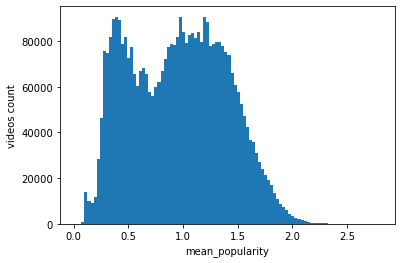

In [169]:
histogram(filtered_videos_df, 'mean_popularity', xname='mean_popularity', yname='videos count')

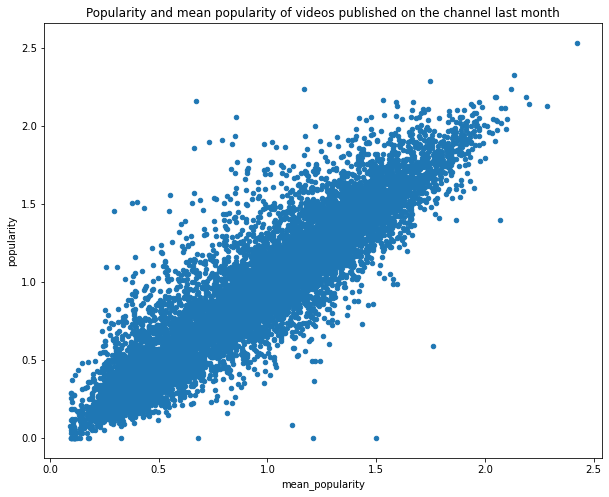

In [170]:
samp_size=10000
true_samp_size = min(samp_size/filtered_videos_df.count(), 1.0)
pd_df = filtered_videos_df.sample(False, true_samp_size).toPandas()

pd_df.plot.scatter(x='mean_popularity', y='popularity', figsize=(10, 8))
plt.ylabel('popularity')
plt.title('Popularity and mean popularity of videos published on the channel last month')
plt.show()

In [171]:
filtered_videos_df.printSchema()

root
 |-- ChannelId: string (nullable = true)
 |-- Description: string (nullable = false)
 |-- Published_date: timestamp (nullable = true)
 |-- Thumbnails: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- caption: boolean (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- definition: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- licensedContent: boolean (nullable = true)
 |-- status: boolean (nullable = true)
 |-- tags: string (nullable = true)
 |-- log_views_Scaled: double (nullable = true)
 |-- log_likes_Scaled: double (nullable = true)
 |-- log_commentCount_Scaled: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- log_duration: double (nullable = true)
 |-- has_tags: boolean (nullable = true)
 |-- proc_tags: array (nullable = true)
 |    |-- element: st

In [172]:
filtered_videos_df = filtered_videos_df.drop('|', 
                                             'proc_tags', 
                                             'log_views_Scaled', 
                                             'log_likes_Scaled', 
                                             'log_commentCount_Scaled')

In [173]:
filtered_videos_df = filtered_videos_df.drop('id',
                                             'tags',
                                             'duration',
                                             'Title',
                                             'Thumbnails',
                                             'Description')

In [174]:
filtered_videos_df.printSchema()

root
 |-- ChannelId: string (nullable = true)
 |-- Published_date: timestamp (nullable = true)
 |-- caption: boolean (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- definition: string (nullable = true)
 |-- licensedContent: boolean (nullable = true)
 |-- status: boolean (nullable = true)
 |-- popularity: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- log_duration: double (nullable = true)
 |-- has_tags: boolean (nullable = true)
 |-- has_pop_tags: boolean (nullable = true)
 |-- title_len: integer (nullable = true)
 |-- title_is_uppercase: boolean (nullable = true)
 |-- title_has_excl: boolean (nullable = true)
 |-- title_has_tags: boolean (nullable = true)
 |-- has_description: boolean (nullable = false)
 |-- emoji_in_title: boolean (nullable = false)
 |-- description_len: double (nullable = true)
 |-- description_has_tags: boolean (

In [176]:
final_df = filtered_videos_df.drop('ChannelId', 'Published_date')

In [178]:
final_df = final_df.na.drop()

In [180]:
final_df.coalesce(1).write.format('json').save("hdfs:///home/ljamschikova-362109/processed")

## Channel age and popularity

In [181]:
filtered_videos_df = (filtered_videos_df
                 .join(channels_df, filtered_videos_df.ChannelId == channels_df.Channel_id, 'left')
                 .select(filtered_videos_df["*"], channels_df.PublishedAt))

In [182]:
filtered_videos_df = (filtered_videos_df.withColumnRenamed('PublishedAt', 'channel_creation_date'))

In [183]:
filtered_videos_df = (filtered_videos_df
                      .withColumn('channel_creation_date', 
                                  F.to_timestamp(filtered_videos_df.channel_creation_date) + 
                                  F.expr('INTERVAL 3 HOURS')))

In [185]:
filtered_videos_df = (filtered_videos_df
                      .withColumn('channel_age', 
                                  F.col("Published_date").cast("long") - F.col('channel_creation_date').cast("long"))
                      .withColumn('video_age', F.round(F.col('channel_age')/3600)))

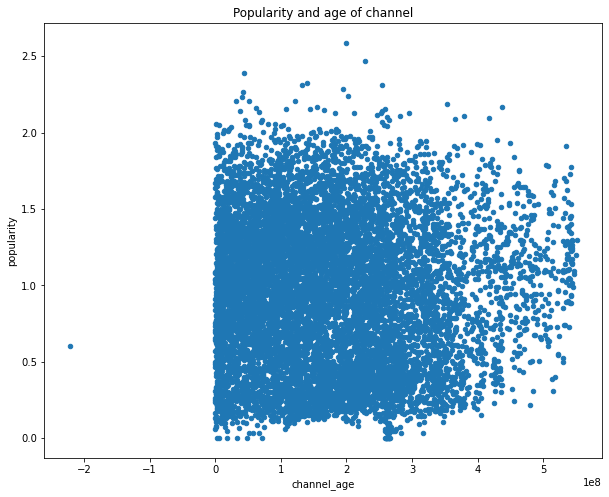

In [189]:
samp_size=10000
true_samp_size = min(samp_size/3977836, 1.0)
pd_df = filtered_videos_df.sample(False, true_samp_size).toPandas()

pd_df.plot.scatter(x='channel_age', y='popularity', figsize=(10, 8))
plt.ylabel('popularity')
plt.title('Popularity and age of channel')
plt.show()

## Video age and popularity

In [186]:
filtered_videos_df = (filtered_videos_df
                      .withColumn('curr_time', F.current_timestamp())
                      .withColumn('video_age', 
                                  F.col('curr_time').cast("long")- F.col("Published_date").cast("long"))
                      .withColumn('video_age', F.round(F.col('video_age')/3600)))

In [ ]:
samp_size=10000
true_samp_size = min(samp_size/3977836, 1.0)
pd_df = filtered_videos_df.select('video_age', 'popularity').sample(False, true_samp_size).toPandas()

pd_df.plot.scatter(x='video_age', y='popularity', figsize=(10, 8))
plt.ylabel('popularity')
plt.title('Popularity and age of videos')
plt.show()

In [187]:
filtered_videos_df.printSchema()

root
 |-- ChannelId: string (nullable = true)
 |-- Published_date: timestamp (nullable = true)
 |-- caption: boolean (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- definition: string (nullable = true)
 |-- licensedContent: boolean (nullable = true)
 |-- status: boolean (nullable = true)
 |-- popularity: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- log_duration: double (nullable = true)
 |-- has_tags: boolean (nullable = true)
 |-- has_pop_tags: boolean (nullable = true)
 |-- title_len: integer (nullable = true)
 |-- title_is_uppercase: boolean (nullable = true)
 |-- title_has_excl: boolean (nullable = true)
 |-- title_has_tags: boolean (nullable = true)
 |-- has_description: boolean (nullable = false)
 |-- emoji_in_title: boolean (nullable = false)
 |-- description_len: double (nullable = true)
 |-- description_has_tags: boolean (

In [188]:
ext_final_df = filtered_videos_df.drop('ChannelId', 'Published_date', 'curr_time', 'channel_creation_date')

In [100]:
filtered_videos_df.count()

3977836

In [103]:
from pyspark.sql.functions import col, when, count
filtered_videos_df.select([count(when(col(c).isNull(), c)).alias(c) for c in filtered_videos_df.columns]).show()

+-------+----------+----------+---------------+-------+----------+-------+-------+---------+-------+------------+--------+------------+---------+------------------+--------------+--------------+---------------+---------------+--------------------+---------------------+---------------+---------+-----------+
|caption|categoryId|definition|licensedContent| status|popularity|   Year|  Month|dayofweek|   hour|log_duration|has_tags|has_pop_tags|title_len|title_is_uppercase|title_has_excl|title_has_tags|has_description|description_len|description_has_tags|description_has_links|mean_popularity|video_age|channel_age|
+-------+----------+----------+---------------+-------+----------+-------+-------+---------+-------+------------+--------+------------+---------+------------------+--------------+--------------+---------------+---------------+--------------------+---------------------+---------------+---------+-----------+
|3977836|   3977836|   3977836|        3977836|3977836|   3977836|3977836|39

In [105]:
filtered_videos_df = filtered_videos_df.na.fill(value=0, subset=["mean_popularity"])

In [106]:
filtered_videos_df = filtered_videos_df.na.drop()

In [112]:
filtered_videos_df.show(10)

Py4JJavaError: An error occurred while calling o1825.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 10 in stage 172.0 failed 4 times, most recent failure: Lost task 10.3 in stage 172.0 (TID 13266) (10.128.159.203 executor 506): org.apache.spark.util.TaskCompletionListenerException: Memory was leaked by query. Memory leaked: (65536)
Allocator(stdin reader for python3) 0/65536/133120/9223372036854775807 (res/actual/peak/limit)


Previous exception in task: Connection reset
	java.base/java.net.SocketInputStream.read(SocketInputStream.java:186)
	java.base/java.net.SocketInputStream.read(SocketInputStream.java:140)
	java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:252)
	java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:271)
	java.base/java.io.DataInputStream.readInt(DataInputStream.java:392)
	org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:74)
	org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:67)
	org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source)
	org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	org.apache.spark.scheduler.Task.run(Task.scala:131)
	org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	java.base/java.lang.Thread.run(Thread.java:834)
	at org.apache.spark.TaskContextImpl.invokeListeners(TaskContextImpl.scala:145)
	at org.apache.spark.TaskContextImpl.markTaskCompleted(TaskContextImpl.scala:124)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:472)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3696)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:772)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2929)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:301)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:338)
	at jdk.internal.reflect.GeneratedMethodAccessor348.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.util.TaskCompletionListenerException: Memory was leaked by query. Memory leaked: (65536)
Allocator(stdin reader for python3) 0/65536/133120/9223372036854775807 (res/actual/peak/limit)


Previous exception in task: Connection reset
	java.base/java.net.SocketInputStream.read(SocketInputStream.java:186)
	java.base/java.net.SocketInputStream.read(SocketInputStream.java:140)
	java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:252)
	java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:271)
	java.base/java.io.DataInputStream.readInt(DataInputStream.java:392)
	org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:74)
	org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:67)
	org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source)
	org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	org.apache.spark.scheduler.Task.run(Task.scala:131)
	org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	java.base/java.lang.Thread.run(Thread.java:834)
	at org.apache.spark.TaskContextImpl.invokeListeners(TaskContextImpl.scala:145)
	at org.apache.spark.TaskContextImpl.markTaskCompleted(TaskContextImpl.scala:124)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [104]:
filtered_videos_df.printSchema()

root
 |-- caption: boolean (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- definition: string (nullable = true)
 |-- licensedContent: boolean (nullable = true)
 |-- status: boolean (nullable = true)
 |-- popularity: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- log_duration: double (nullable = true)
 |-- has_tags: boolean (nullable = true)
 |-- has_pop_tags: boolean (nullable = true)
 |-- title_len: integer (nullable = true)
 |-- title_is_uppercase: boolean (nullable = true)
 |-- title_has_excl: boolean (nullable = true)
 |-- title_has_tags: boolean (nullable = true)
 |-- has_description: boolean (nullable = false)
 |-- description_len: integer (nullable = false)
 |-- description_has_tags: boolean (nullable = true)
 |-- description_has_links: boolean (nullable = true)
 |-- mean_popularity: double (nullable = true)
 |-- video_age: do

In [111]:
filtered_videos_df.coalesce(1).write.format('json').save("hdfs:///home/ljamschikova-362109/processed")

Py4JJavaError: An error occurred while calling o1840.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:231)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:188)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:108)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:106)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:131)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:132)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:131)
	at org.apache.spark.sql.DataFrameWriter.$anonfun$runCommand$1(DataFrameWriter.scala:989)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:772)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:989)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:438)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:415)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:293)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 7 in stage 165.0 failed 4 times, most recent failure: Lost task 7.3 in stage 165.0 (TID 13105) (10.128.17.8 executor 1): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:550)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:539)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:89)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:67)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:397)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:74)
	... 21 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:200)
	... 32 more
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:550)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:539)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:89)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:67)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:397)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:74)
	... 21 more


In [113]:
spark.stop()